# PIGPVAE cooling R4 model
The main difference to traditional VAE model (Kigma et al., 2014) is that instead of using standard gaussian distibutions on the latent vector $\mathbf{Z} = [\mathbf{z}_1, \ldots, \mathbf{z}_L],$ where $\mathbf{z}_l \sim \mathcal{N}(0, \sigma^2I),$ we use GPs that account for the depedency that we have in time. Therefore we have that $\mathbf{z}_l \sim \mathcal{N}(0, K(t,t'\mid \theta_l)),$ where $K$ is a function that models the correlation that we have in time. 

This is in principle a conditional (in time) generator. Another advantage of using GPs for the latent variables, is that we do not need the data to be equally spaced in time. It is also possible to condition on other features. For example, the outer temperature, solar irradiance, wind, ...

The main drawback with GPs is the cubic in data $\mathcal{O}(N^3)$ cost and the vanilla GP model can not be trained in mini-batches.
To overcome the cost we can use reliable approximations (e.g. Titsias 2009) that reduce the cost to $\mathcal{O}(Nm^2),$ where $m$ is a user the number of so called inducing points (user choice, usually 20-30 is fine). At the same time there are two recent papers that make GPs ammenable to mini-batching (add refs).

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *
from VAE_utils import AnnealingStrategy

# from Models.PIGPVAE_cooling import PIGPVAE
# from Models.PIGPVAE_heating import PIGPVAE
from Models.PIGPVAE_lognorm import PIGPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD417'] + df['B.ASTRHT2.T'])/2
df_c = df.copy()
df_c = df[df['temp_change_class'] == 'c']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_c = df_c.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_4440/3618831305.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_c = df_c.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var):
        self.df = df
        self.select_var = select_var
        self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch
# Initialize the dataset and train_loader
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_c,select_var)
# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

# Define a fixed seed for reproducibility
# seed = 10
seed = 0
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

In [39]:
len(dataset)


28

In [4]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

# Initialize the VAE
torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ReLU(),
                trainable_alpha=True,
                initial_alpha=0.1
               )

In [5]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha

# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [6]:
def find_rbf_lengthscale(kernel):
    if isinstance(kernel, gpytorch.kernels.RBFKernel):
        return kernel.lengthscale.item()
    elif hasattr(kernel, 'base_kernel'):
        return find_rbf_lengthscale(kernel.base_kernel)
    elif hasattr(kernel, 'kernels'):
        for k in kernel.kernels:
            result = find_rbf_lengthscale(k)
            if result is not None:
                return result
    return None

In [7]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)


Training Progress:   5%|▍         | 29/600 [00:02<00:52, 10.80it/s]

Epoch 30: Train Loss = 1.6280, KL_phy = 0.1645, KL_delta = -0.2422, MSE = 1.6255, CE = 1.2529, Reg_Loss = 0.0455, Alpha = 0.0960
Validation Loss = 1.1419, Val_KL_phy = 0.1600, Val_KL_delta = -0.2249, Val_MSE = 1.1396, Val_CE = 1.2189, Val_Reg_Loss = 0.0399, Val_Alpha = 0.0960


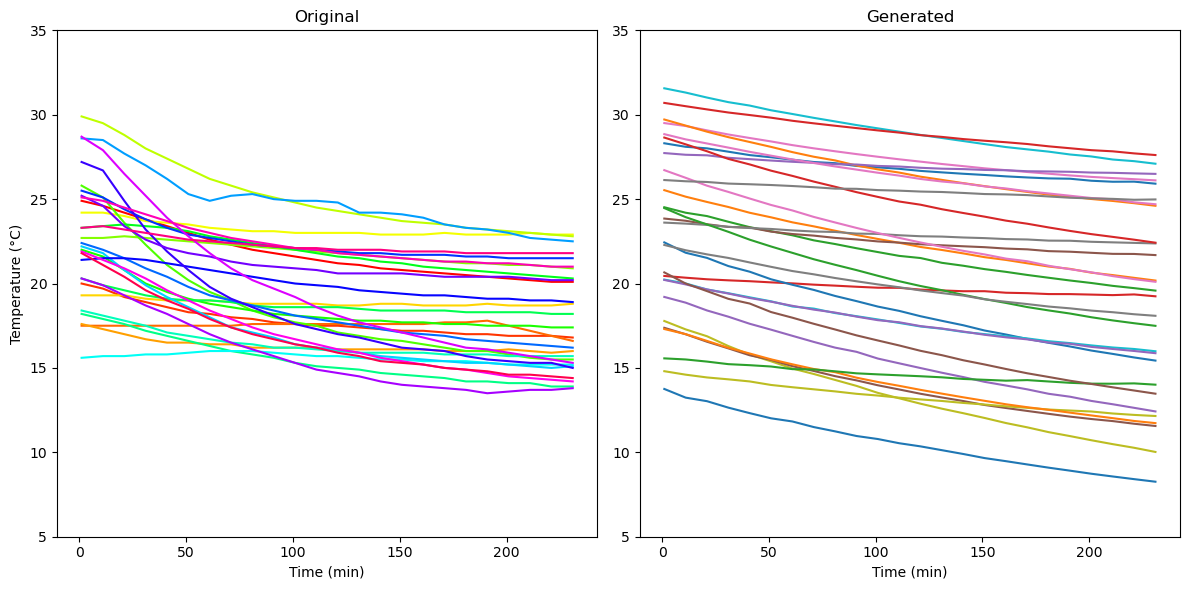

Training Progress:  10%|▉         | 59/600 [00:05<00:49, 10.91it/s]

Epoch 60: Train Loss = 1.2435, KL_phy = 0.2231, KL_delta = 0.0245, MSE = 1.2192, CE = 0.5715, Reg_Loss = 0.1340, Alpha = 0.0902
Validation Loss = 1.5700, Val_KL_phy = 0.2231, Val_KL_delta = 0.0763, Val_MSE = 1.5447, Val_CE = 0.5427, Val_Reg_Loss = 0.1173, Val_Alpha = 0.0901


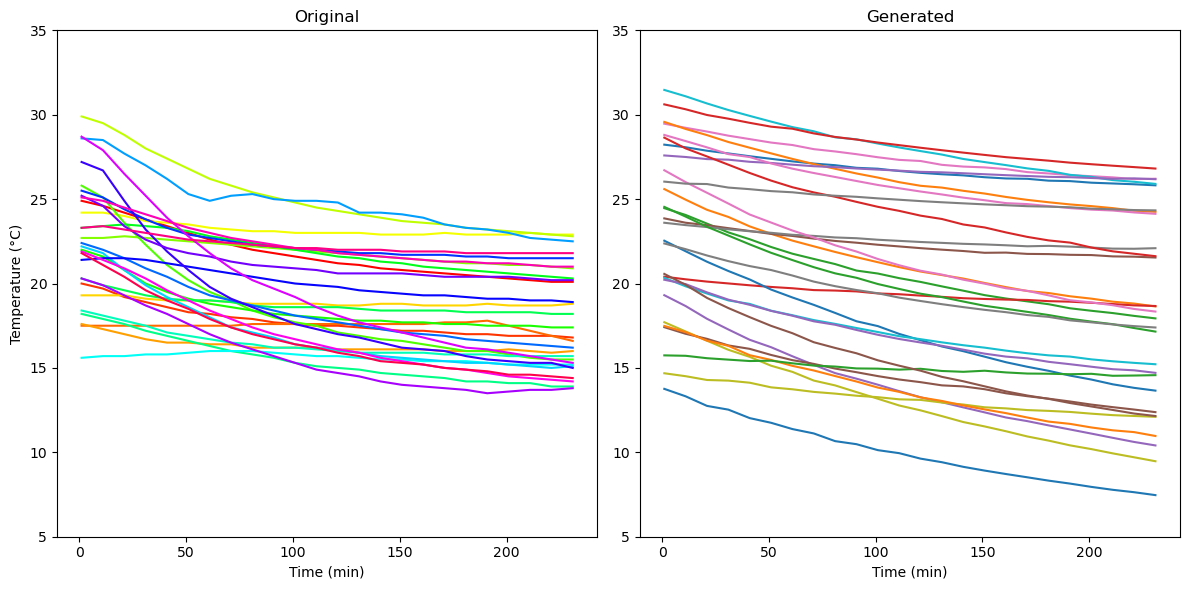

Training Progress:  15%|█▍        | 88/600 [00:08<00:46, 10.97it/s]

Epoch 90: Train Loss = 1.0997, KL_phy = 0.2814, KL_delta = 0.1082, MSE = 1.0436, CE = 0.2469, Reg_Loss = 0.3249, Alpha = 0.0835
Validation Loss = 1.5489, Val_KL_phy = 0.2795, Val_KL_delta = 0.1578, Val_MSE = 1.4979, Val_CE = 0.1911, Val_Reg_Loss = 0.2214, Val_Alpha = 0.0834


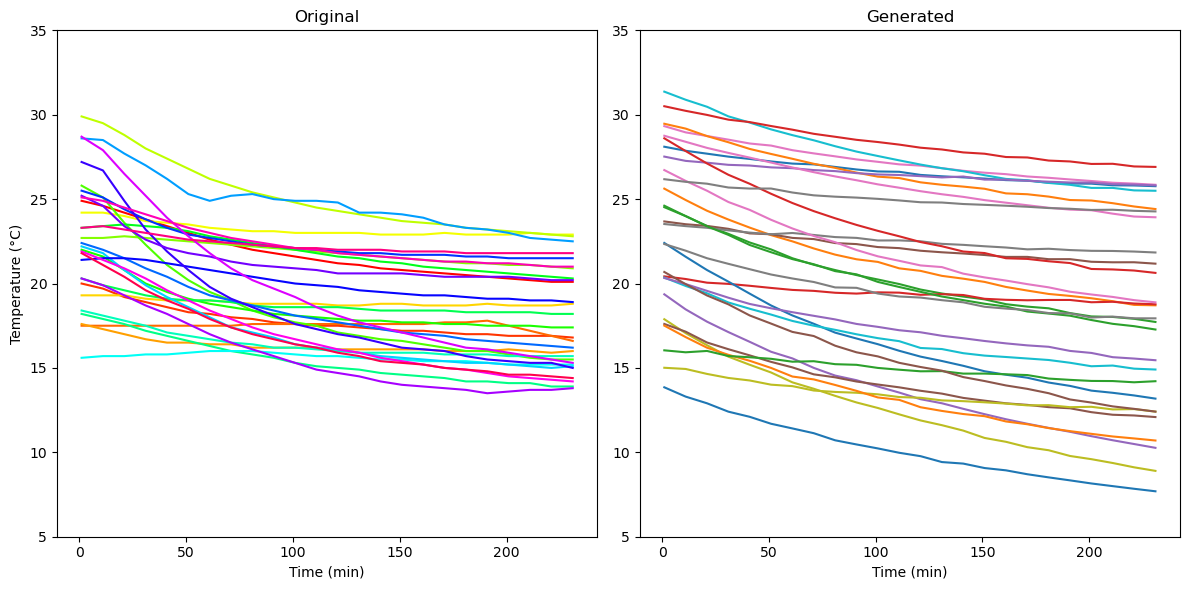

Training Progress:  20%|█▉        | 118/600 [00:11<00:44, 10.95it/s]

Epoch 120: Train Loss = 1.0453, KL_phy = 0.3354, KL_delta = 0.1755, MSE = 0.9498, CE = 0.1498, Reg_Loss = 0.5779, Alpha = 0.0775
Validation Loss = 1.1548, Val_KL_phy = 0.3313, Val_KL_delta = 0.2096, Val_MSE = 1.0777, Val_CE = 0.1086, Val_Reg_Loss = 0.3017, Val_Alpha = 0.0774


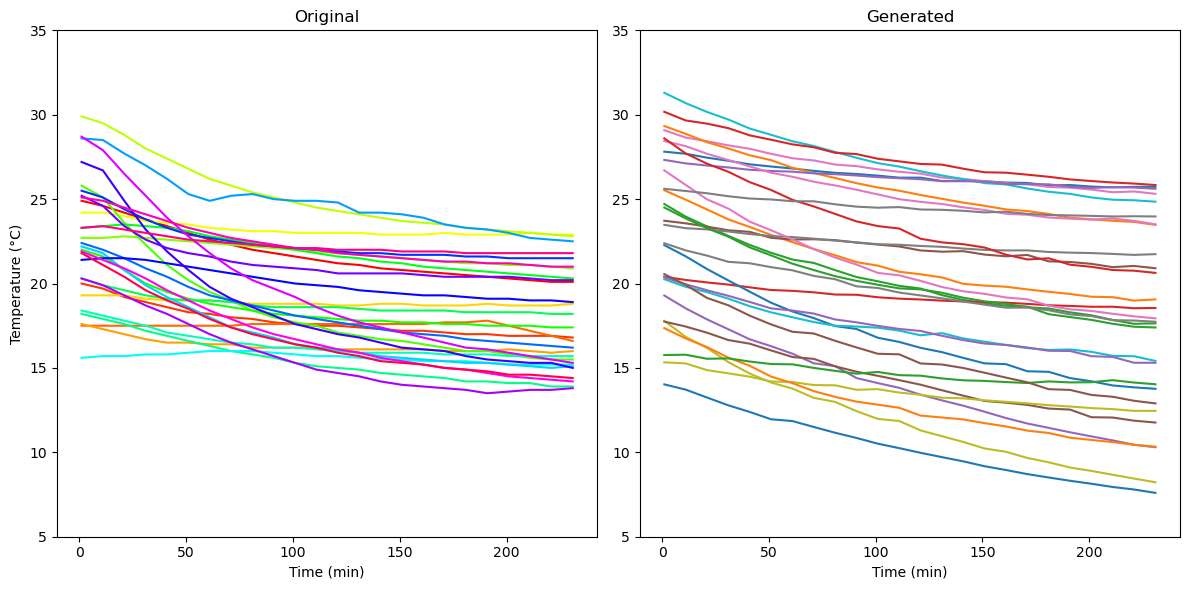

Training Progress:  25%|██▍       | 148/600 [00:14<00:41, 10.76it/s]

Epoch 150: Train Loss = 1.0195, KL_phy = 0.3474, KL_delta = 0.2058, MSE = 0.8881, CE = 0.0880, Reg_Loss = 0.8626, Alpha = 0.0725
Validation Loss = 1.1213, Val_KL_phy = 0.3444, Val_KL_delta = 0.2432, Val_MSE = 1.0137, Val_CE = 0.1134, Val_Reg_Loss = 0.4761, Val_Alpha = 0.0725


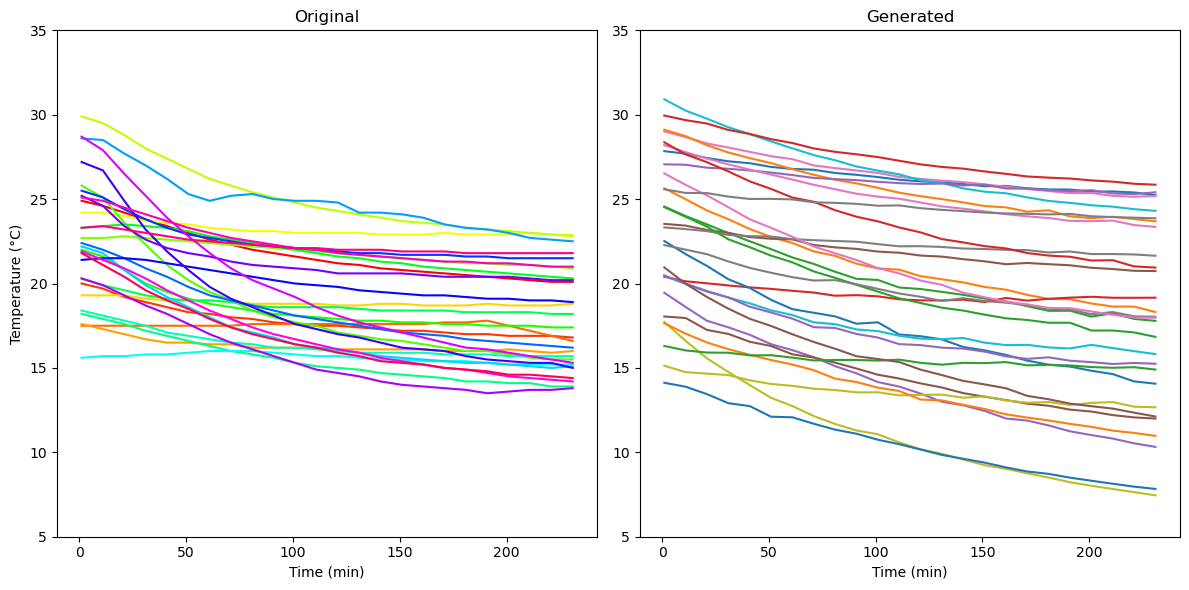

Training Progress:  30%|██▉       | 178/600 [00:17<00:39, 10.68it/s]

Epoch 180: Train Loss = 0.9968, KL_phy = 0.3157, KL_delta = 0.2121, MSE = 0.8575, CE = 0.0858, Reg_Loss = 0.8818, Alpha = 0.0686
Validation Loss = 1.0892, Val_KL_phy = 0.3126, Val_KL_delta = 0.2473, Val_MSE = 0.9808, Val_CE = 0.0900, Val_Reg_Loss = 0.3608, Val_Alpha = 0.0685


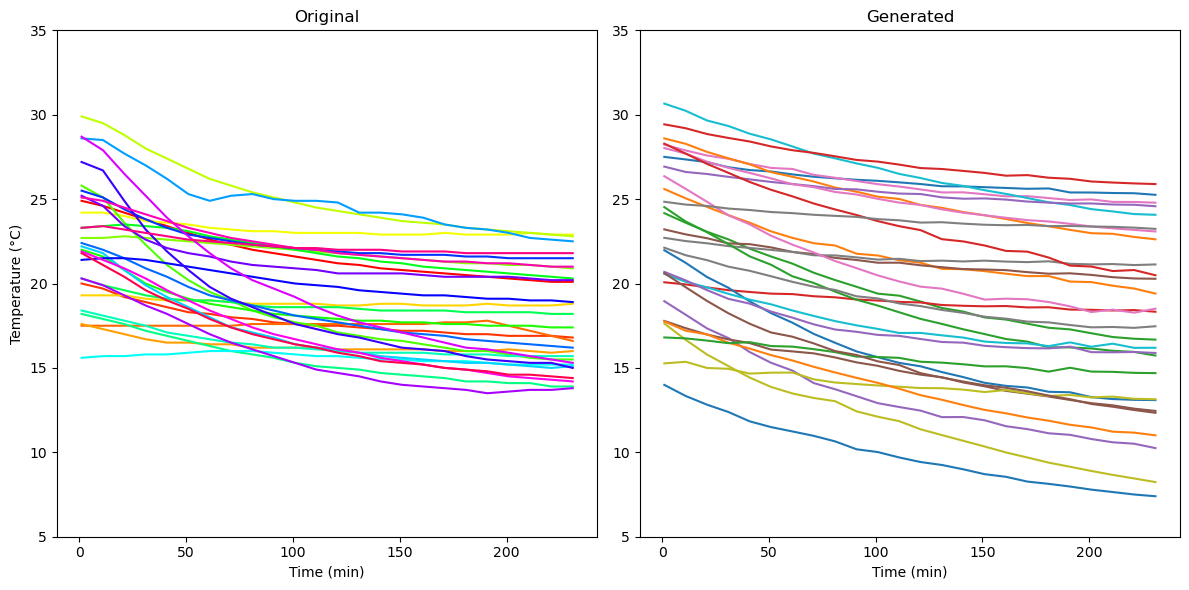

Training Progress:  35%|███▍      | 209/600 [00:20<00:36, 10.60it/s]

Epoch 210: Train Loss = 0.9960, KL_phy = 0.2895, KL_delta = 0.2365, MSE = 0.8388, CE = 0.0949, Reg_Loss = 1.0043, Alpha = 0.0651
Validation Loss = 1.1656, Val_KL_phy = 0.2905, Val_KL_delta = 0.2935, Val_MSE = 1.0430, Val_CE = 0.0847, Val_Reg_Loss = 0.3189, Val_Alpha = 0.0651


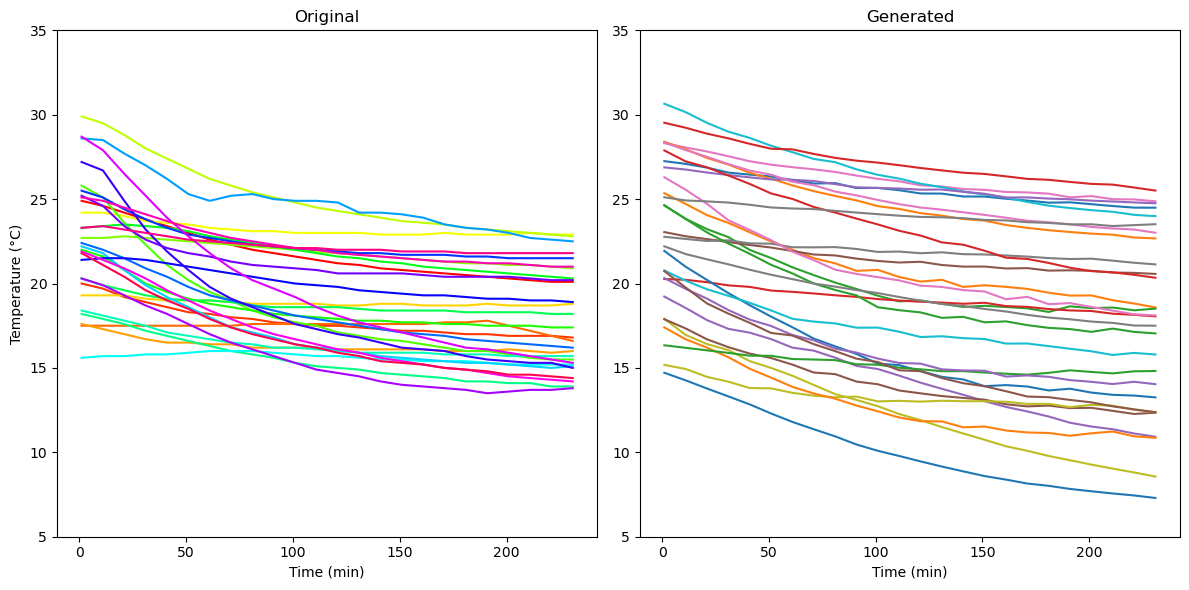

Training Progress:  40%|███▉      | 238/600 [00:23<00:33, 10.90it/s]

Epoch 240: Train Loss = 0.9130, KL_phy = 0.2711, KL_delta = 0.2680, MSE = 0.7471, CE = 0.1004, Reg_Loss = 0.9406, Alpha = 0.0620
Validation Loss = 1.2394, Val_KL_phy = 0.2702, Val_KL_delta = 0.3351, Val_MSE = 1.0937, Val_CE = 0.1138, Val_Reg_Loss = 0.4018, Val_Alpha = 0.0619


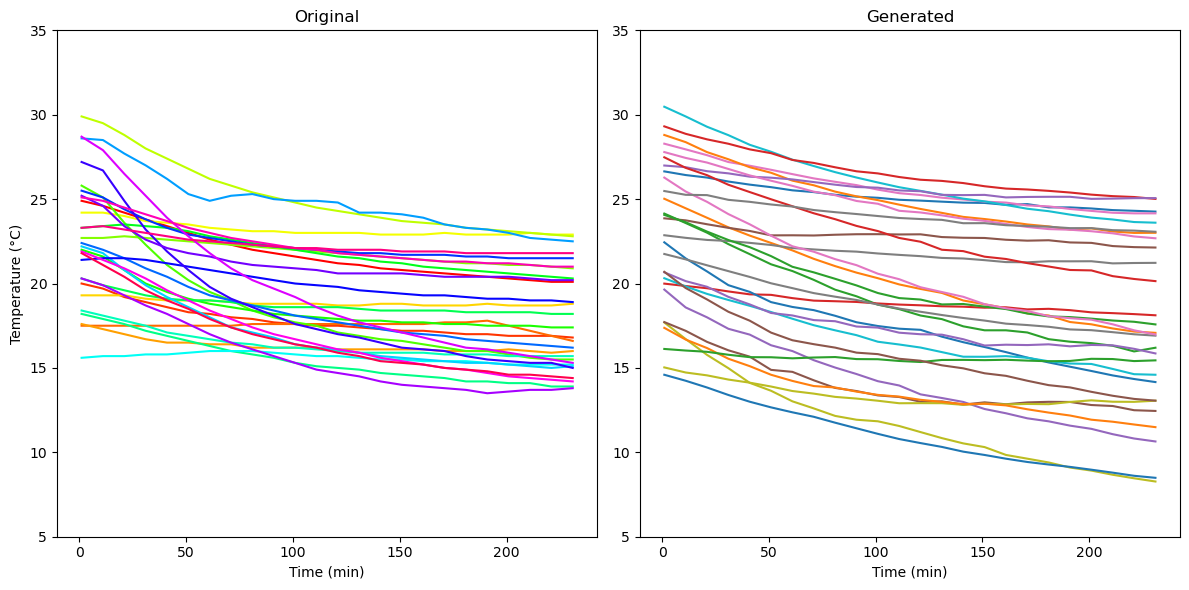

Training Progress:  45%|████▍     | 268/600 [00:26<00:30, 10.84it/s]

Epoch 270: Train Loss = 0.8792, KL_phy = 0.1942, KL_delta = 0.2801, MSE = 0.6950, CE = 0.0953, Reg_Loss = 1.3115, Alpha = 0.0593
Validation Loss = 0.8056, Val_KL_phy = 0.1967, Val_KL_delta = 0.3506, Val_MSE = 0.6599, Val_CE = 0.0980, Val_Reg_Loss = 0.3836, Val_Alpha = 0.0592


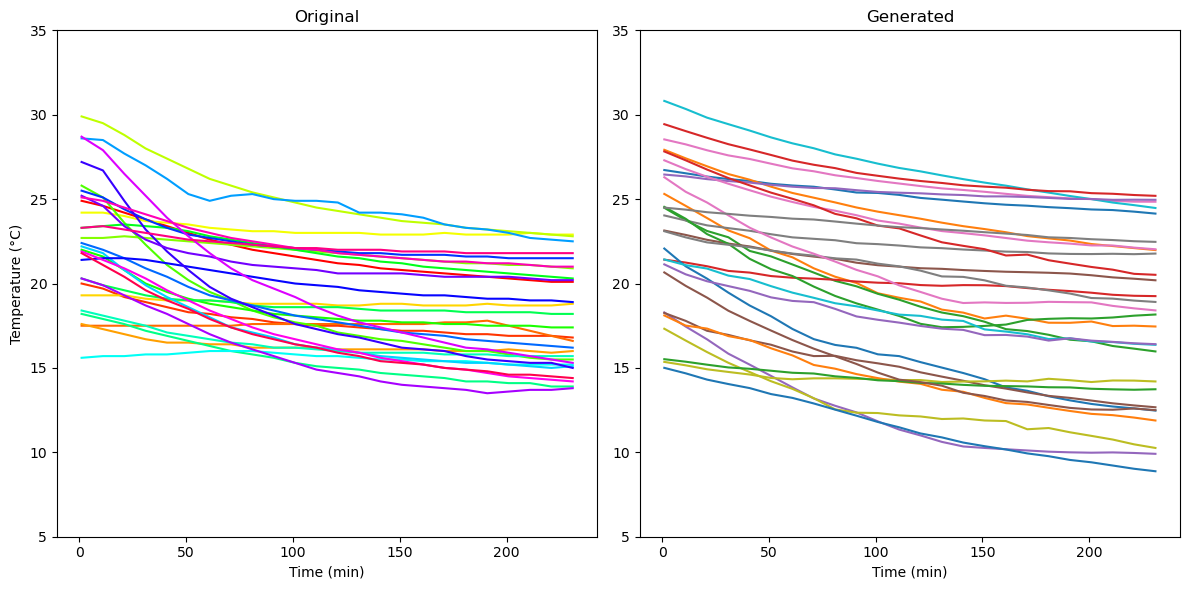

Training Progress:  50%|████▉     | 298/600 [00:29<00:27, 10.91it/s]

Epoch 300: Train Loss = 0.7825, KL_phy = 0.1282, KL_delta = 0.2683, MSE = 0.6299, CE = 0.1011, Reg_Loss = 0.9442, Alpha = 0.0568
Validation Loss = 0.8072, Val_KL_phy = 0.1294, Val_KL_delta = 0.3226, Val_MSE = 0.6728, Val_CE = 0.0916, Val_Reg_Loss = 0.3791, Val_Alpha = 0.0567


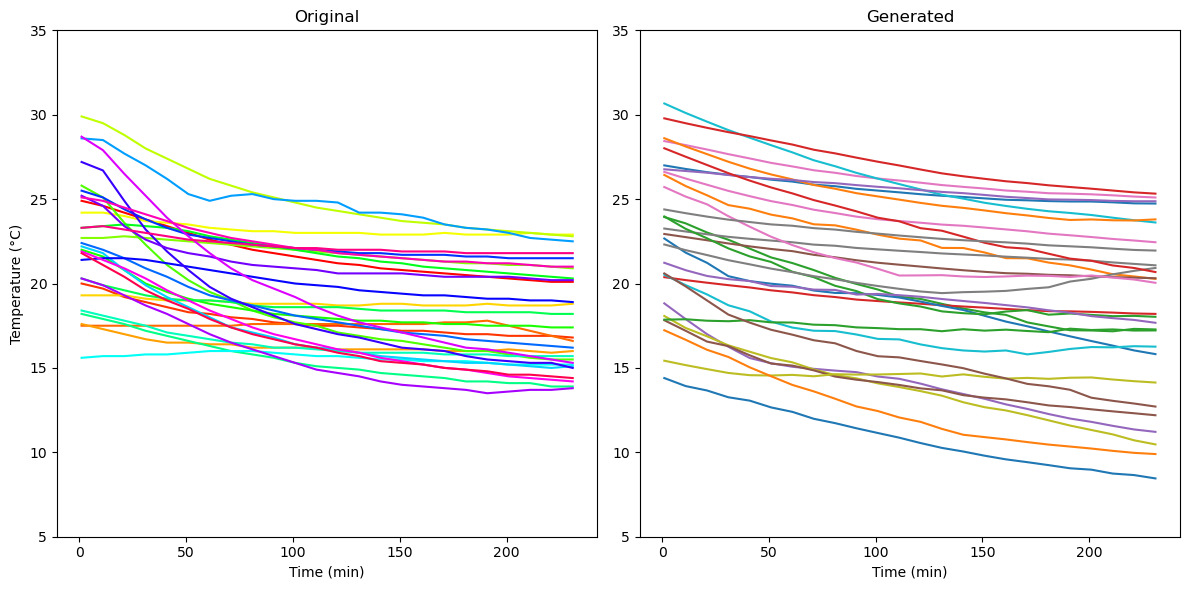

Training Progress:  55%|█████▍    | 328/600 [00:31<00:24, 10.89it/s]

Epoch 330: Train Loss = 0.7634, KL_phy = 0.1700, KL_delta = 0.2365, MSE = 0.5930, CE = 0.0751, Reg_Loss = 1.0815, Alpha = 0.0544
Validation Loss = 0.6811, Val_KL_phy = 0.1746, Val_KL_delta = 0.3142, Val_MSE = 0.5197, Val_CE = 0.0795, Val_Reg_Loss = 0.5011, Val_Alpha = 0.0543


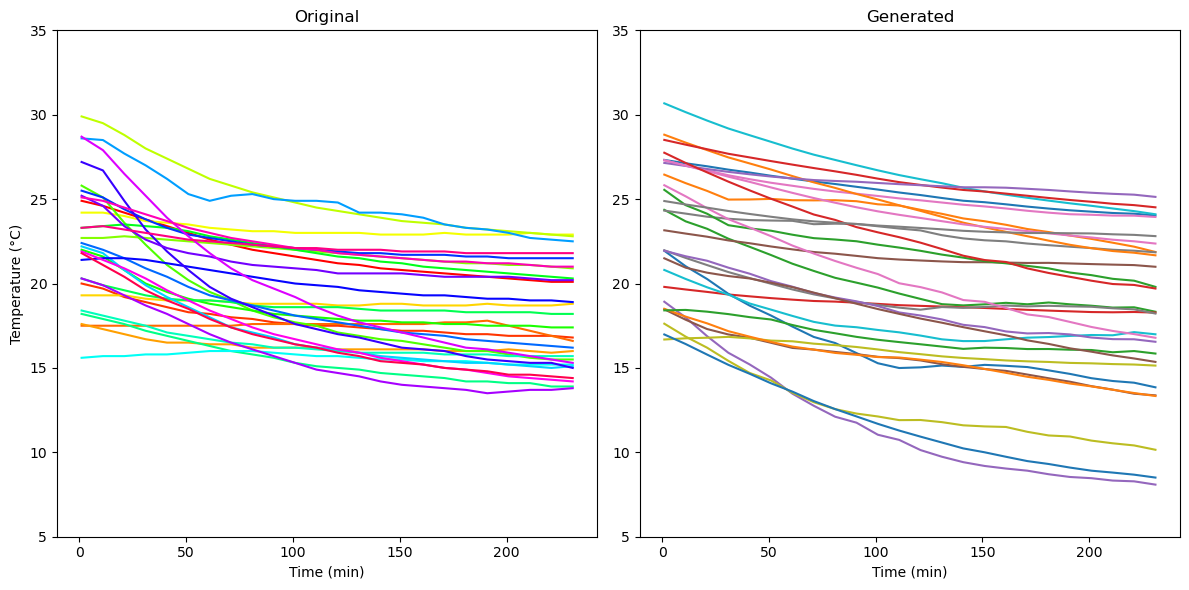

Training Progress:  60%|█████▉    | 358/600 [00:34<00:22, 10.78it/s]

Epoch 360: Train Loss = 0.6587, KL_phy = 0.1437, KL_delta = 0.2046, MSE = 0.4983, CE = 0.0680, Reg_Loss = 1.0745, Alpha = 0.0521
Validation Loss = 0.6206, Val_KL_phy = 0.1394, Val_KL_delta = 0.2833, Val_MSE = 0.4683, Val_CE = 0.0749, Val_Reg_Loss = 0.4902, Val_Alpha = 0.0521


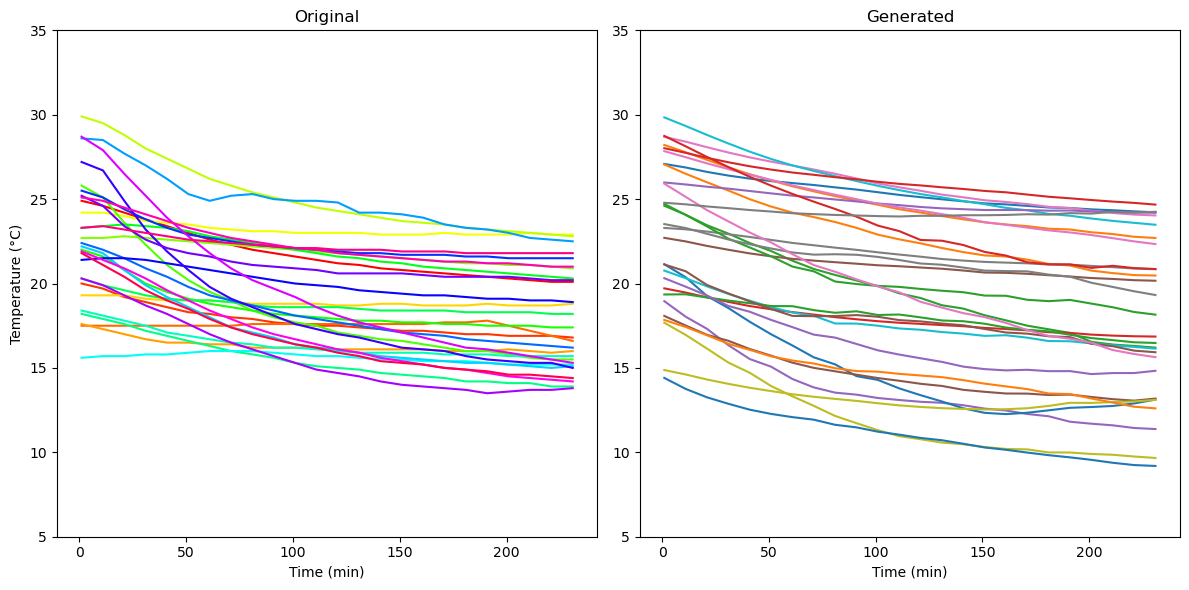

Training Progress:  65%|██████▍   | 388/600 [00:37<00:19, 10.82it/s]

Epoch 390: Train Loss = 0.8235, KL_phy = 0.1276, KL_delta = 0.1868, MSE = 0.6499, CE = 0.0695, Reg_Loss = 1.4289, Alpha = 0.0501
Validation Loss = 0.6645, Val_KL_phy = 0.1491, Val_KL_delta = 0.2481, Val_MSE = 0.5095, Val_CE = 0.0620, Val_Reg_Loss = 0.5192, Val_Alpha = 0.0500


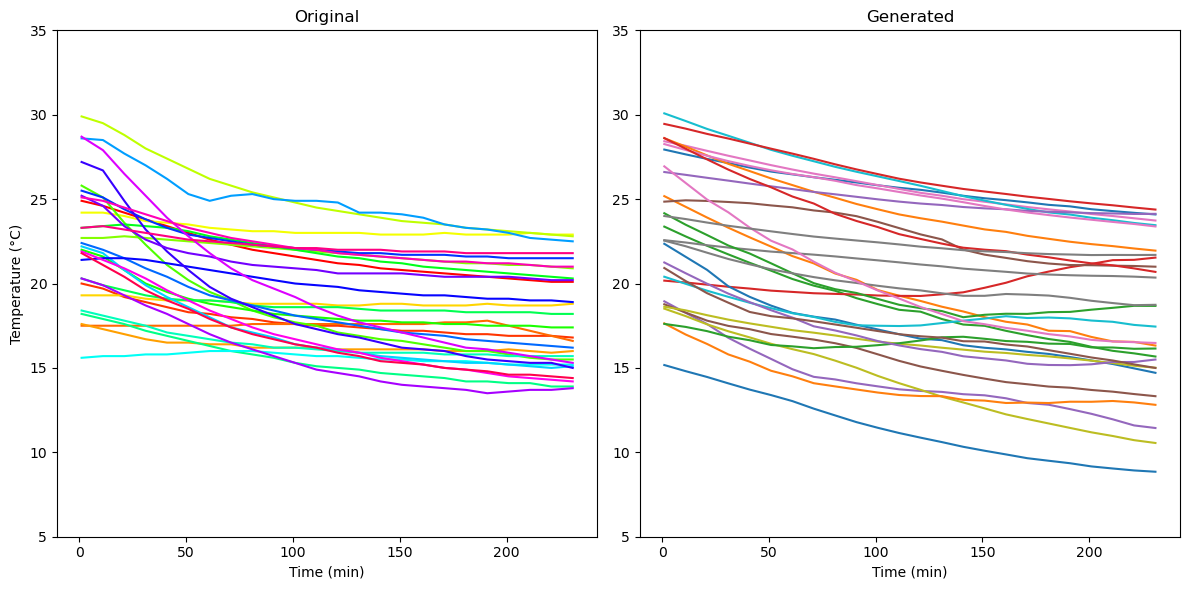

Training Progress:  70%|██████▉   | 419/600 [00:40<00:16, 10.91it/s]

Epoch 420: Train Loss = 0.6923, KL_phy = 0.0974, KL_delta = 0.1566, MSE = 0.5324, CE = 0.0558, Reg_Loss = 1.4764, Alpha = 0.0481
Validation Loss = 0.6228, Val_KL_phy = 0.1020, Val_KL_delta = 0.2118, Val_MSE = 0.4951, Val_CE = 0.0594, Val_Reg_Loss = 0.3724, Val_Alpha = 0.0481


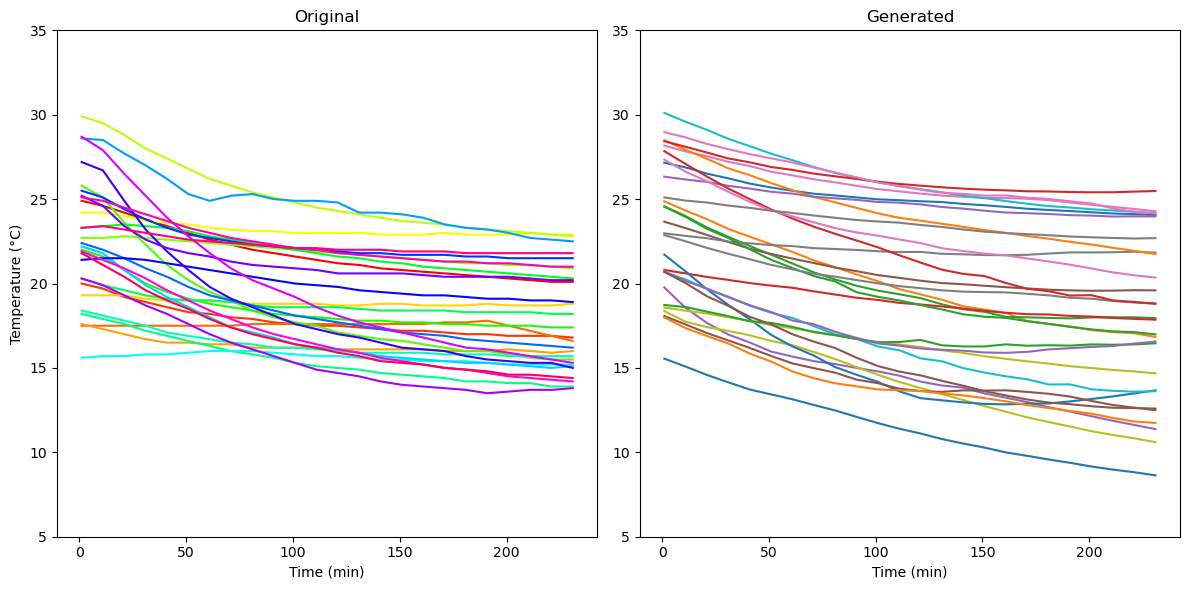

Training Progress:  75%|███████▍  | 449/600 [00:43<00:13, 11.04it/s]

Epoch 450: Train Loss = 0.7213, KL_phy = 0.1084, KL_delta = 0.1205, MSE = 0.5929, CE = 0.0419, Reg_Loss = 0.9190, Alpha = 0.0462
Validation Loss = 0.5119, Val_KL_phy = 0.1063, Val_KL_delta = 0.1973, Val_MSE = 0.3745, Val_CE = 0.0614, Val_Reg_Loss = 0.5106, Val_Alpha = 0.0462


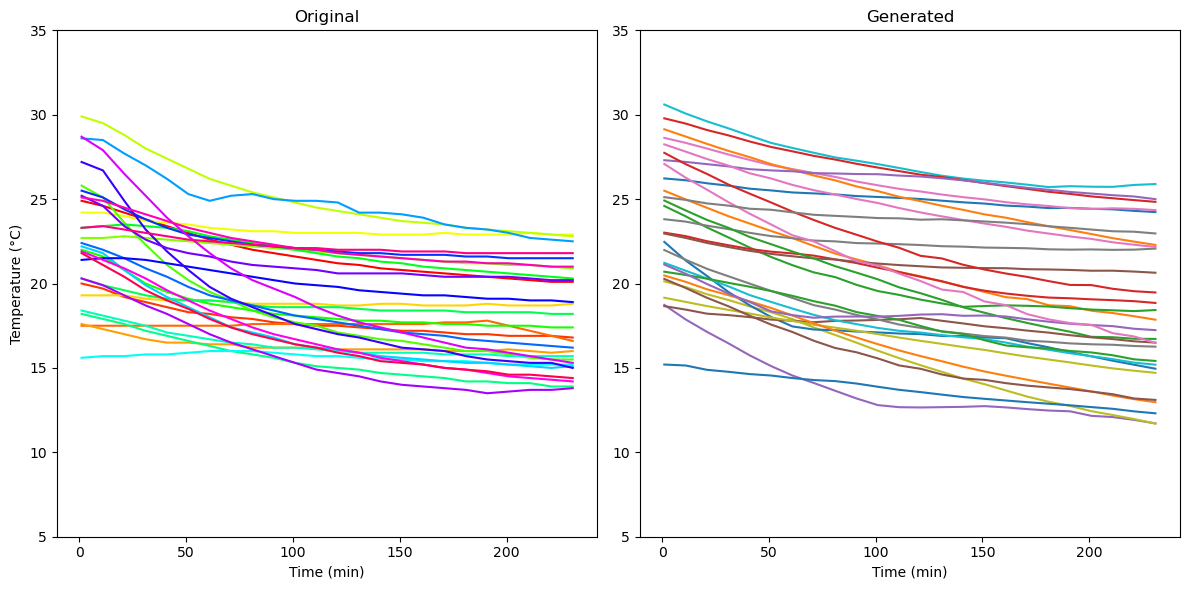

Training Progress:  80%|███████▉  | 478/600 [00:46<00:11, 10.76it/s]

Epoch 480: Train Loss = 0.6138, KL_phy = 0.0875, KL_delta = 0.0983, MSE = 0.4899, CE = 0.0373, Reg_Loss = 1.1142, Alpha = 0.0445
Validation Loss = 0.4903, Val_KL_phy = 0.0880, Val_KL_delta = 0.1654, Val_MSE = 0.3658, Val_CE = 0.0546, Val_Reg_Loss = 0.5211, Val_Alpha = 0.0445


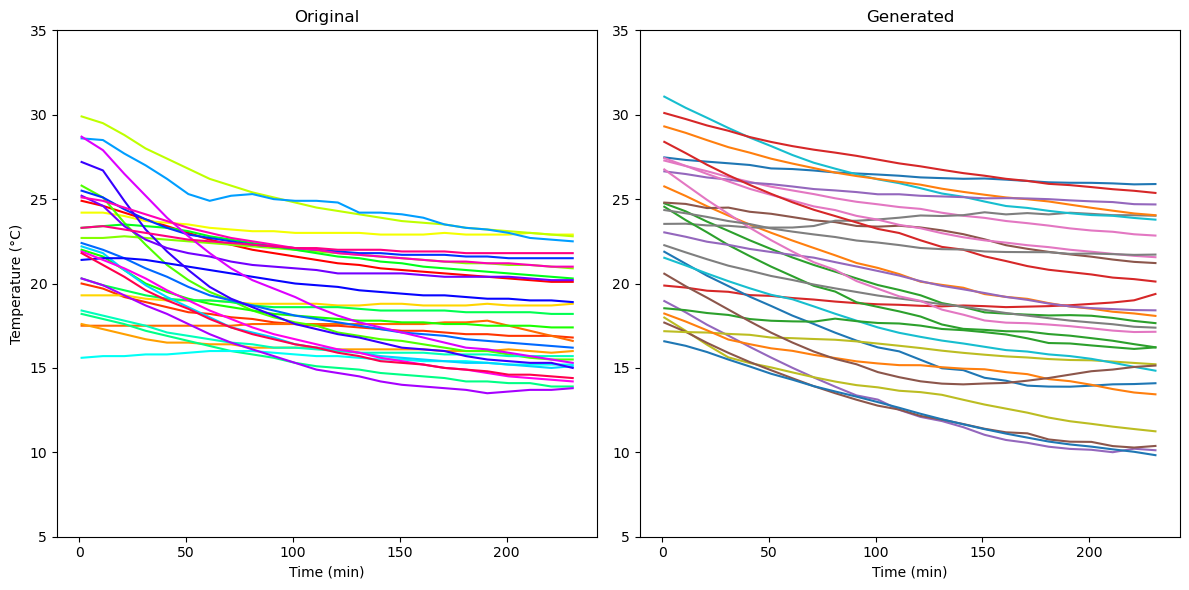

Training Progress:  85%|████████▍ | 508/600 [00:49<00:08, 10.86it/s]

Epoch 510: Train Loss = 0.6704, KL_phy = 0.0889, KL_delta = 0.0849, MSE = 0.5417, CE = 0.0358, Reg_Loss = 1.2799, Alpha = 0.0429
Validation Loss = 0.6531, Val_KL_phy = 0.1004, Val_KL_delta = 0.1401, Val_MSE = 0.5184, Val_CE = 0.0477, Val_Reg_Loss = 0.7593, Val_Alpha = 0.0428


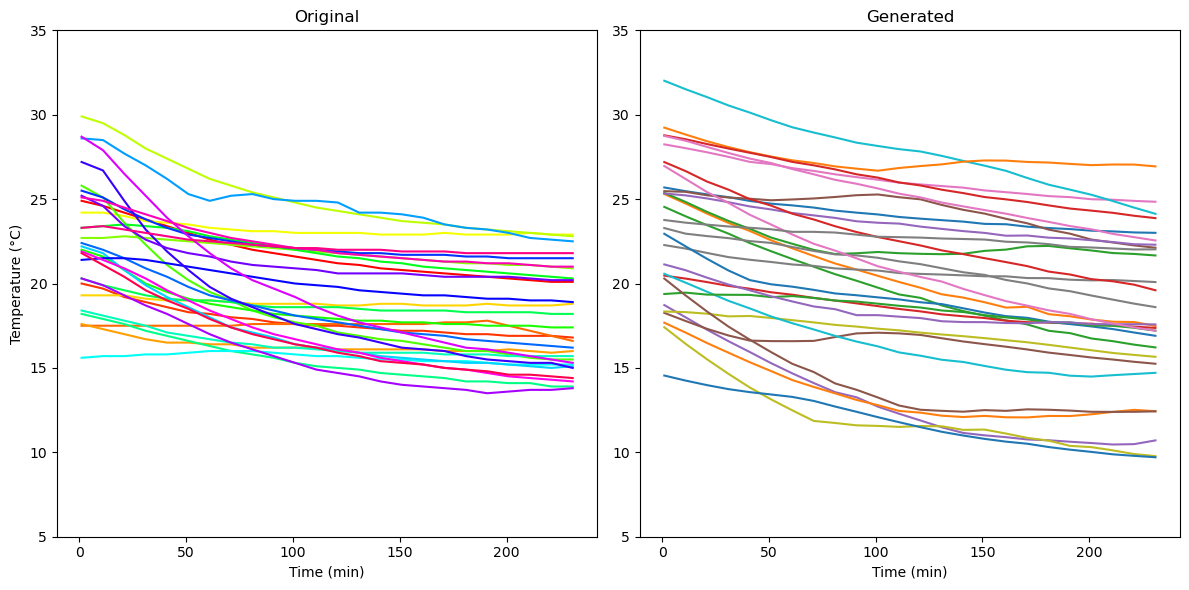

Training Progress:  90%|████████▉ | 538/600 [00:52<00:05, 10.90it/s]

Epoch 540: Train Loss = 0.6496, KL_phy = 0.0737, KL_delta = 0.0632, MSE = 0.5256, CE = 0.0330, Reg_Loss = 1.5135, Alpha = 0.0413
Validation Loss = 0.5650, Val_KL_phy = 0.0765, Val_KL_delta = 0.1185, Val_MSE = 0.4453, Val_CE = 0.0429, Val_Reg_Loss = 0.7754, Val_Alpha = 0.0412


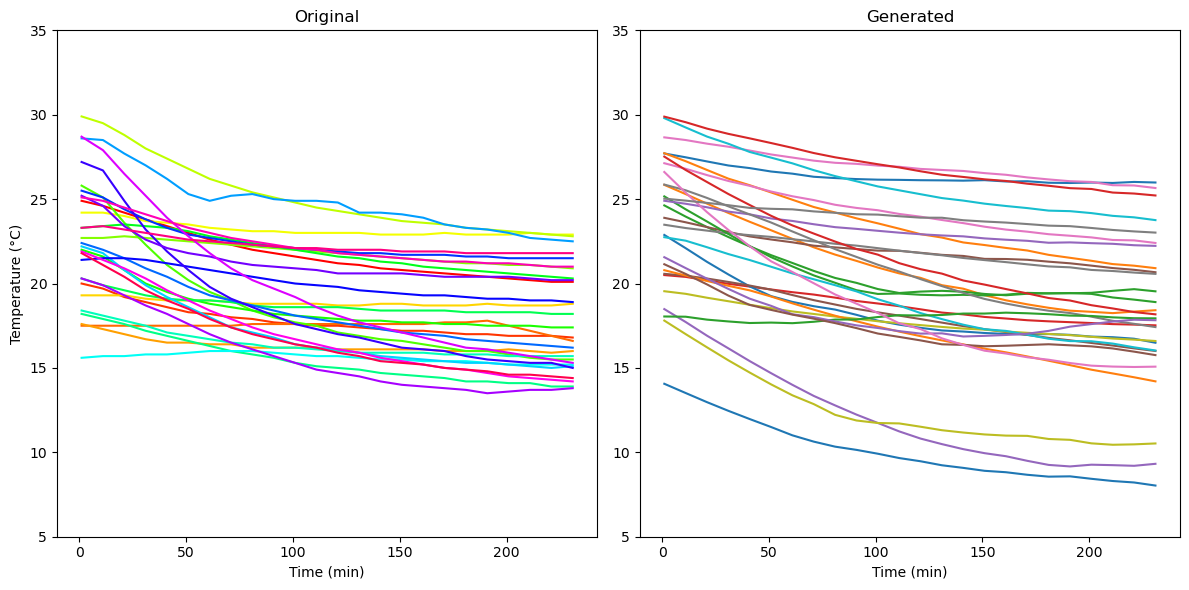

Training Progress:  95%|█████████▍| 568/600 [00:55<00:02, 10.85it/s]

Epoch 570: Train Loss = 0.6467, KL_phy = 0.0827, KL_delta = 0.0418, MSE = 0.5273, CE = 0.0461, Reg_Loss = 1.5210, Alpha = 0.0397
Validation Loss = 0.9186, Val_KL_phy = 0.0870, Val_KL_delta = 0.0970, Val_MSE = 0.8062, Val_CE = 0.0409, Val_Reg_Loss = 0.6297, Val_Alpha = 0.0396


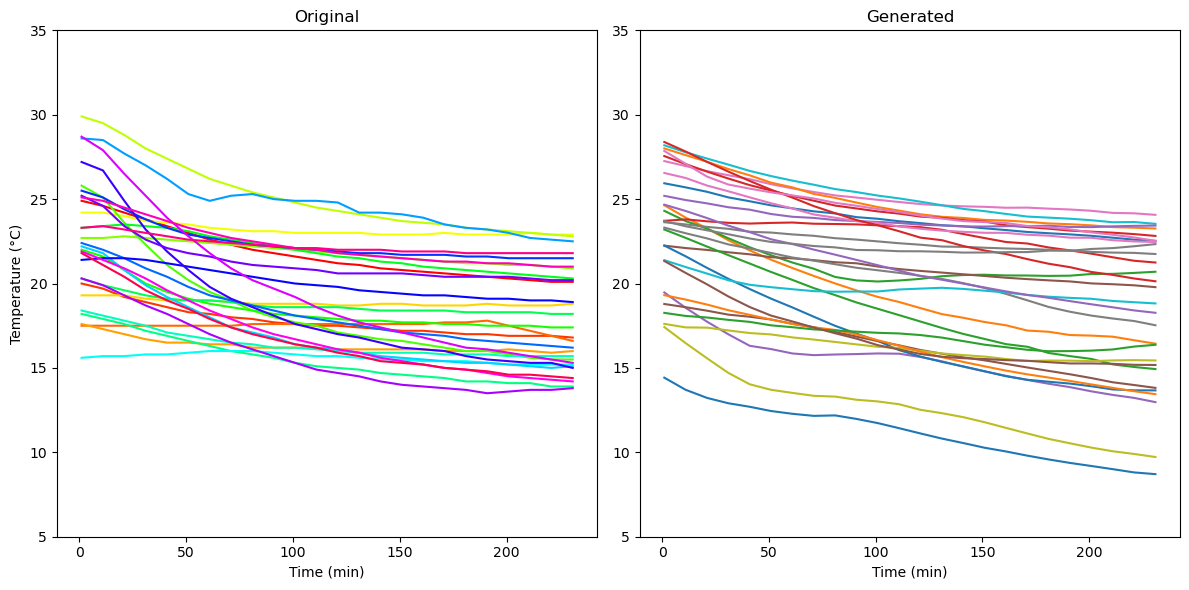

Training Progress: 100%|█████████▉| 598/600 [00:58<00:00, 10.81it/s]

Epoch 600: Train Loss = 0.6674, KL_phy = 0.0759, KL_delta = 0.0262, MSE = 0.5514, CE = 0.0289, Reg_Loss = 1.7022, Alpha = 0.0382
Validation Loss = 0.6830, Val_KL_phy = 0.0784, Val_KL_delta = 0.0886, Val_MSE = 0.5802, Val_CE = 0.0405, Val_Reg_Loss = 0.5055, Val_Alpha = 0.0381


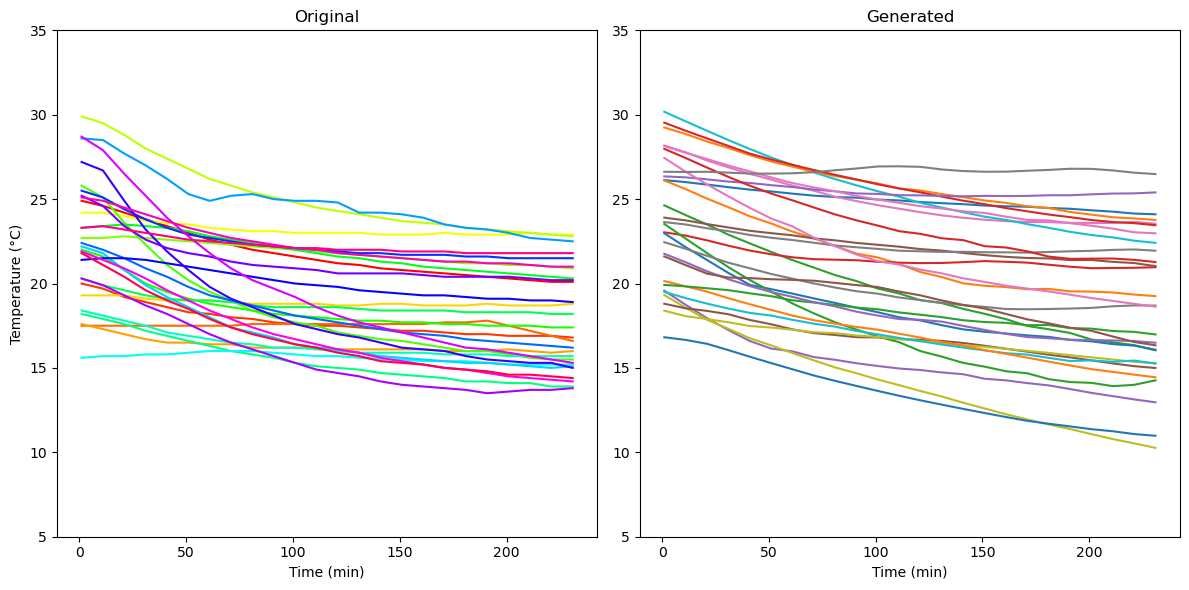

Training Progress: 100%|██████████| 600/600 [00:58<00:00, 10.25it/s]


In [8]:
"""
# works well
beta=0.01
beta_delta=beta#*0.001
"""
# beta=0.01
# beta=0.05

# beta_delta=beta
# beta_phy=beta
# Training configuration
# num_epochs=1000
num_epochs=600
epochs=range(num_epochs)
"""
annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.00001, 
                                       beta_max=1)
"""

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.0001, 
                                       beta_max=0.5)
beta_annealed = annealing_strategy.get_beta_vector()
# beta_annealed = torch.tensor(beta_annealed)
beta_delta=beta_annealed
beta_phy=beta_annealed
ns = total_size
min_T, max_T = 13, 32
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (15 - 1) * torch.rand(ns)
Ts = T0 - difference
unique_intervals = df_c['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_c, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(5, 35))
# !!! Make it works with plot=True

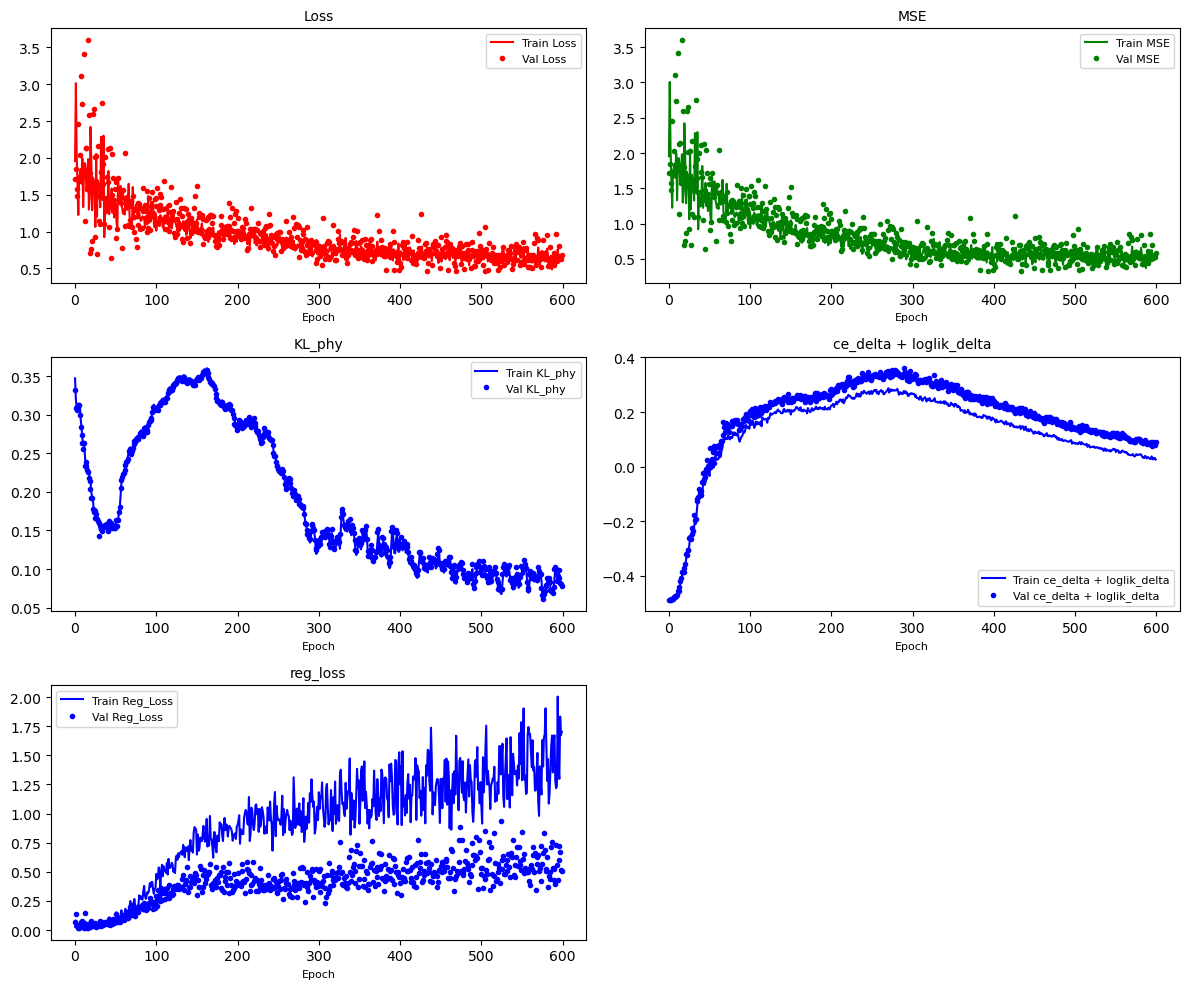

In [9]:
# Extract quantities for plotting
epochs = fit_res['epochs']
l_loss = fit_res['train_loss']
val_loss = fit_res['val_loss']
mse = fit_res['train_mse']
val_mse = fit_res['val_mse']
KL_phy = fit_res['train_KL_phy']
val_KL_phy = fit_res['val_KL_phy']
KL_delta = fit_res['train_KL_delta']
val_KL_delta = fit_res['val_KL_delta']
reg_loss = fit_res['train_reg_loss']
val_reg_loss = fit_res['val_reg_loss']

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(12, 10))  # Keeping original figure size

# Loss plot (train vs. validation)
axs[0, 0].plot(epochs, l_loss, 'r-', label='Train Loss')
axs[0, 0].plot(epochs, val_loss, 'ro', label='Val Loss', markersize=3)  # Only points for validation
axs[0, 0].set_title('Loss', fontsize=10)
axs[0, 0].set_xlabel('Epoch', fontsize=8)
axs[0, 0].legend(fontsize=8)

# MSE plot (train vs. validation)
axs[0, 1].plot(epochs, mse, 'g-', label='Train MSE')
axs[0, 1].plot(epochs, val_mse, 'go', label='Val MSE', markersize=3)  # Only points for validation
axs[0, 1].set_title('MSE', fontsize=10)
axs[0, 1].set_xlabel('Epoch', fontsize=8)
axs[0, 1].legend(fontsize=8)

# KL Divergence (train vs. validation)
axs[1, 0].plot(epochs, KL_phy, 'b-', label='Train KL_phy')
axs[1, 0].plot(epochs, val_KL_phy, 'bo', label='Val KL_phy', markersize=3)  # Only points for validation
axs[1, 0].set_title('KL_phy', fontsize=10)
axs[1, 0].set_xlabel('Epoch', fontsize=8)
axs[1, 0].legend(fontsize=8)

# KL_delta + loglik_delta (train vs. validation)
axs[1, 1].plot(epochs, KL_delta, 'b-', label='Train ce_delta + loglik_delta')
axs[1, 1].plot(epochs, val_KL_delta, 'bo', label='Val ce_delta + loglik_delta', markersize=3)  # Only points for validation
axs[1, 1].set_title('ce_delta + loglik_delta', fontsize=10)
axs[1, 1].set_xlabel('Epoch', fontsize=8)
axs[1, 1].legend(fontsize=8)

# Regularization loss (train vs. validation) - Spanning entire third row
axs[2, 0].plot(epochs, reg_loss, 'b-', label='Train Reg_Loss')
axs[2, 0].plot(epochs, val_reg_loss, 'bo', label='Val Reg_Loss', markersize=3)  # Only points for validation
axs[2, 0].set_title('reg_loss', fontsize=10)
axs[2, 0].set_xlabel('Epoch', fontsize=8)
axs[2, 0].legend(fontsize=8)

# Remove empty subplot (since we have 5 plots, and this grid would have 6 subplots)
fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [10]:
q_mu_delta_l, q_var_delta_l, q_mu_phy_l, q_var_phy_l, x_hat_l, x_hat_phy_l, x_hat_delta_l, = [], [], [], [], [], [], []
batches_data = []
# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    with torch.no_grad():
        x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary

        x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)

        q_mu_delta_l.append(q_mu_delta_i)
        q_var_delta_l.append(q_var_delta_i)
        q_mu_phy_l.append(q_mu_phy_i)
        q_var_phy_l.append(q_var_phy_i)
        x_hat_l.append(x_hat_i)
        x_hat_phy_l.append(x_hat_phy_i)
        x_hat_delta_l.append(x_hat_delta_i)
        batches_data.append(x_batch)
        
mean_q_mu_phy = sum(q_mu_phy_l) / len(q_mu_phy_l)
mean_q_var_phy = sum(q_var_phy_l) / len(q_var_phy_l)
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)


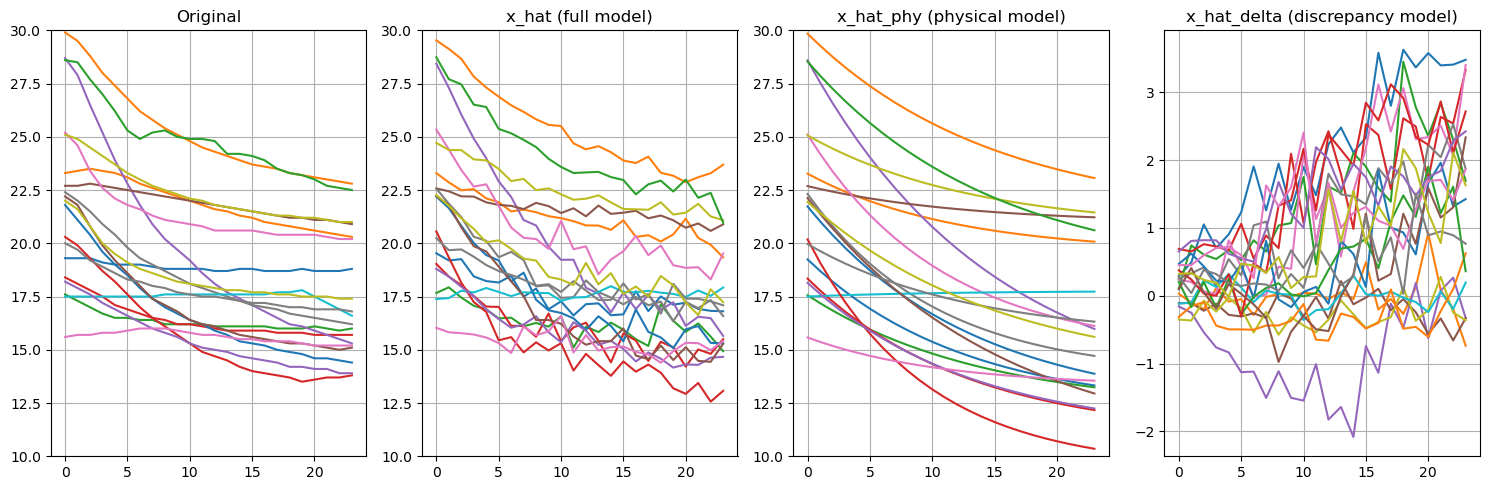

In [11]:
x_hat_numpy = [x_hat_l[sa].numpy() for sa in range(len(x_hat_l))]
batches_data_numpy = [batches_data[sa][:, 0].unsqueeze(1).numpy() for sa in range(len(batches_data))]
x_hat_phy_numpy = [x_hat_phy_l[sa].numpy() for sa in range(len(x_hat_phy_l))]
x_hat_delta_numpy = [x_hat_delta_l[sa].numpy() for sa in range(len(x_hat_delta_l))]

# Number of subplots is the length of the lists (assuming all have the same length)
num_plots = len(x_hat_numpy)

# Create subplots - 1 row, 4 columns
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

# Plot each list in a separate subplot
for i in range(num_plots):
    # First subplot
    axs[0].plot(batches_data_numpy[i], label=f'batches_data[{i}]')
    axs[0].set_title('Original')
    axs[0].set_ylim(10, 30)
    
    # Second subplot
    axs[1].plot(x_hat_numpy[i], label=f'x_hat_l[{i}]')
    axs[1].set_title('x_hat (full model)')
    axs[1].set_ylim(10, 30)
    
    # Third subplot
    axs[2].plot(x_hat_phy_numpy[i], label=f'x_hat_phy_l[{i}]')
    axs[2].set_title('x_hat_phy (physical model)')
    axs[2].set_ylim(10, 30)
    
    # Fourth subplot
    axs[3].plot(x_hat_delta_numpy[i], label=f'x_hat_delta_l[{i}]')
    axs[3].set_title('x_hat_delta (discrepancy model)')

# Add legends to each subplot
for ax in axs:
    ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()


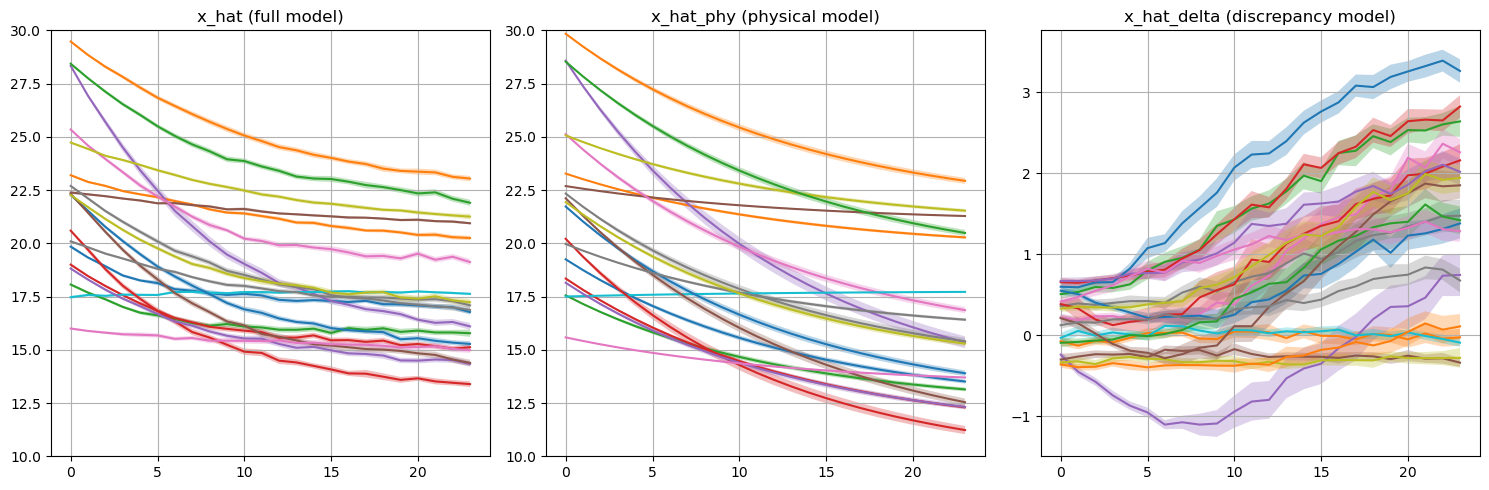

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Function to compute mean and 95% CI
def compute_mean_and_ci(samples):
    samples = np.array(samples)  # Ensure it's a NumPy array
    mean = np.mean(samples, axis=0)  # Mean across samples
    std = np.std(samples, axis=0)   # Standard deviation
    ci = 1.96 * (std / np.sqrt(samples.shape[0]))  # 95% CI using SEM
    return mean, mean - ci, mean + ci

# Initialize lists to store multiple samples
x_hat_samples, x_hat_phy_samples, x_hat_delta_samples = [], [], []

# Number of samples to generate for each quantity
num_samples = 50

# Iterate through the train_loader to obtain x_batch
for x_batch in train_loader:
    x_batch = x_batch.squeeze(0)  # Remove the batch dimension if necessary
    x_hat_batch, x_hat_phy_batch, x_hat_delta_batch = [], [], []
    
    for _ in range(num_samples):
        with torch.no_grad():
            x_hat_i, x_hat_phy_i, x_hat_delta_i, _, _, _, q_mu_delta_i, q_var_delta_i, q_mu_phy_i, q_var_phy_i = model(x_batch)
            x_hat_batch.append(x_hat_i.numpy().flatten())  # Flatten to 1D
            x_hat_phy_batch.append(x_hat_phy_i.numpy().flatten())
            x_hat_delta_batch.append(x_hat_delta_i.numpy().flatten())
    
    # Store all samples for the batch
    x_hat_samples.append(np.stack(x_hat_batch))  # Shape: [num_samples, seq_len]
    x_hat_phy_samples.append(np.stack(x_hat_phy_batch))
    x_hat_delta_samples.append(np.stack(x_hat_delta_batch))

# Plot results with mean and 95% CI
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, (x_hat, x_hat_phy, x_hat_delta) in enumerate(zip(x_hat_samples, x_hat_phy_samples, x_hat_delta_samples)):
    # Compute mean and CI for each quantity
    mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat)
    mean_x_hat_phy, lower_x_hat_phy, upper_x_hat_phy = compute_mean_and_ci(x_hat_phy)
    mean_x_hat_delta, lower_x_hat_delta, upper_x_hat_delta = compute_mean_and_ci(x_hat_delta)

    # Plot Full Model
    axs[0].plot(mean_x_hat, label=f'Batch {i} Mean')
    axs[0].fill_between(range(len(mean_x_hat)), lower_x_hat, upper_x_hat, alpha=0.3, label=f'Batch {i} CI')
    axs[0].set_title('x_hat (full model)')
    axs[0].set_ylim(10, 30)

    # Plot Physical Model
    axs[1].plot(mean_x_hat_phy, label=f'Batch {i} Mean')
    axs[1].fill_between(range(len(mean_x_hat_phy)), lower_x_hat_phy, upper_x_hat_phy, alpha=0.3, label=f'Batch {i} CI')
    axs[1].set_title('x_hat_phy (physical model)')
    axs[1].set_ylim(10, 30)

    # Plot Discrepancy Model
    axs[2].plot(mean_x_hat_delta, label=f'Batch {i} Mean')
    axs[2].fill_between(range(len(mean_x_hat_delta)), lower_x_hat_delta, upper_x_hat_delta, alpha=0.3, label=f'Batch {i} CI')
    axs[2].set_title('x_hat_delta (discrepancy model)')
    #axs[2].set_ylim(10, 30)

# Add legends and display the plot
for ax in axs:
    ax.grid(True)

plt.tight_layout()
plt.show()


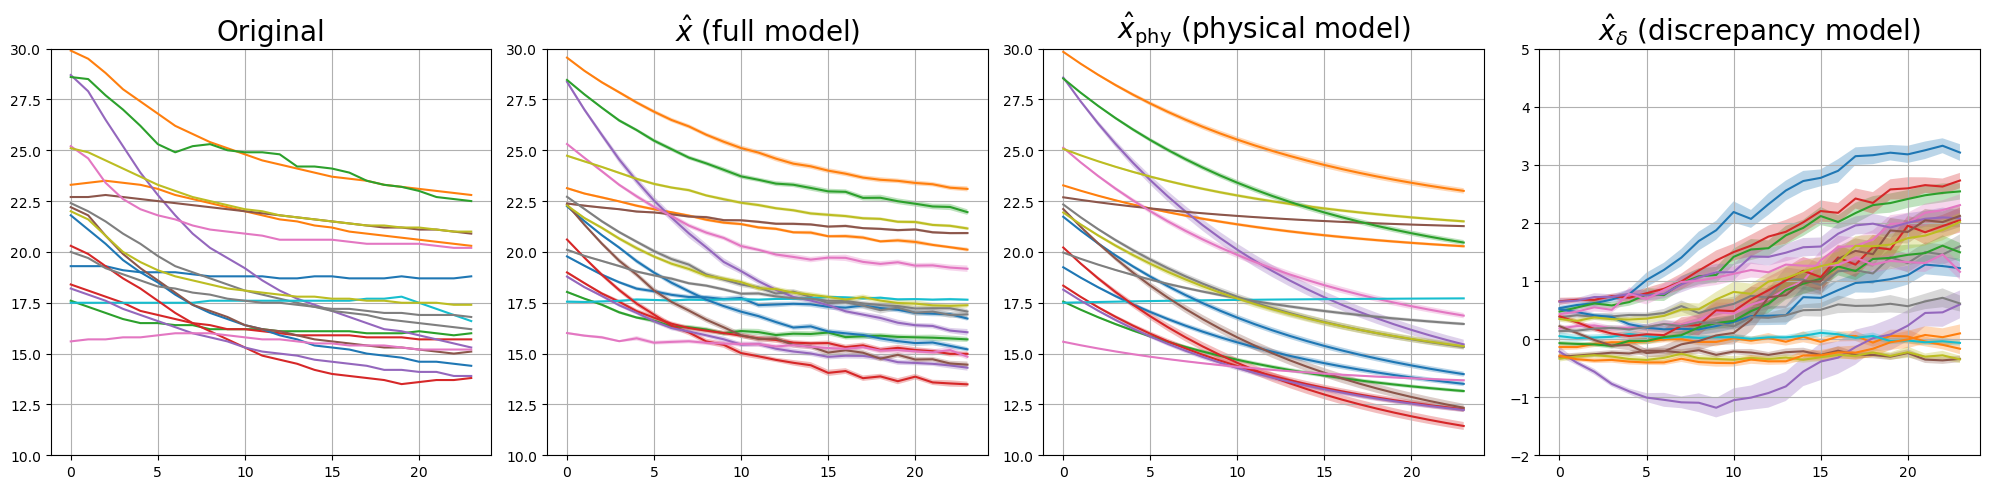

In [46]:
# Plot results with four subplots: real data, full model, physical model, discrepancy model
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Font size for titles
title_fontsize = 20

# Plot Real Data (outside the loop)
for i in range(num_plots):
    # First subplot
    axs[0].plot(batches_data_numpy[i], label=f'batches_data[{i}]')
    axs[0].set_title(r'Original', fontsize=title_fontsize)
    axs[0].set_ylim(10, 30)

# Plot reconstructed quantities for each batch
for i, (x_hat, x_hat_phy, x_hat_delta) in enumerate(zip(x_hat_samples, x_hat_phy_samples, x_hat_delta_samples)):
    # Compute mean and CI for each quantity
    mean_x_hat, lower_x_hat, upper_x_hat = compute_mean_and_ci(x_hat)
    mean_x_hat_phy, lower_x_hat_phy, upper_x_hat_phy = compute_mean_and_ci(x_hat_phy)
    mean_x_hat_delta, lower_x_hat_delta, upper_x_hat_delta = compute_mean_and_ci(x_hat_delta)

    # Plot Full Model
    axs[1].plot(mean_x_hat, label=f'Batch {i} Mean')
    axs[1].fill_between(range(len(mean_x_hat)), lower_x_hat, upper_x_hat, alpha=0.3, label=f'Batch {i} CI')
    axs[1].set_title(r'$\hat{x}$ (full model)', fontsize=title_fontsize)
    axs[1].set_ylim(10, 30)

    # Plot Physical Model
    axs[2].plot(mean_x_hat_phy, label=f'Batch {i} Mean')
    axs[2].fill_between(range(len(mean_x_hat_phy)), lower_x_hat_phy, upper_x_hat_phy, alpha=0.3, label=f'Batch {i} CI')
    axs[2].set_title(r'$\hat{x}_{\text{phy}}$ (physical model)', fontsize=title_fontsize)
    axs[2].set_ylim(10, 30)

    # Plot Discrepancy Model
    axs[3].plot(mean_x_hat_delta, label=f'Batch {i} Mean')
    axs[3].fill_between(range(len(mean_x_hat_delta)), lower_x_hat_delta, upper_x_hat_delta, alpha=0.3, label=f'Batch {i} CI')
    axs[3].set_title(r'$\hat{x}_\delta$ (discrepancy model)', fontsize=title_fontsize)
    axs[3].set_ylim(-2, 5)

# Add legends to reconstructed plots
for ax in axs[0:]:
    # ax.legend()
    ax.grid(True)

# Save the plot as a PDF
plt.tight_layout()
plt.savefig("figs/PIGPVAE_reconstructions_cooling.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()


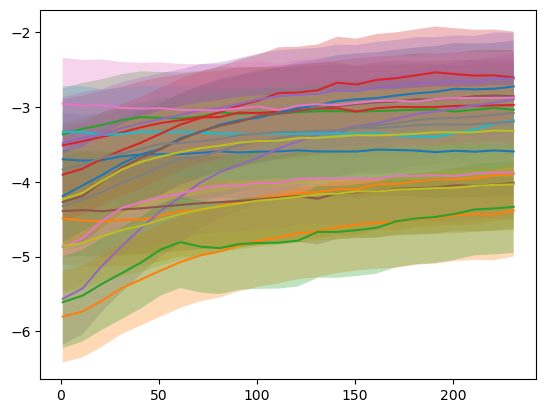

In [14]:
for l in range(len(q_mu_delta_l)):
    with torch.no_grad():
        z_mu, z_var = model.GP.cond_mu_cov(t_uni, t_uni, q_mu_delta_l[l], q_var_delta_l[l].squeeze())
        plt.plot(t_uni,z_mu)
        plt.fill_between(t_uni, y1=z_mu.squeeze()+1.96*z_var.diag().sqrt(), y2=z_mu.squeeze()-1.96*z_var.diag().sqrt(),alpha=0.3, label='1.96*std')
plt.show()  #

In [15]:
mu_s = torch.cat(q_mu_delta_l, dim=1).mean(dim=1).unsqueeze(1)

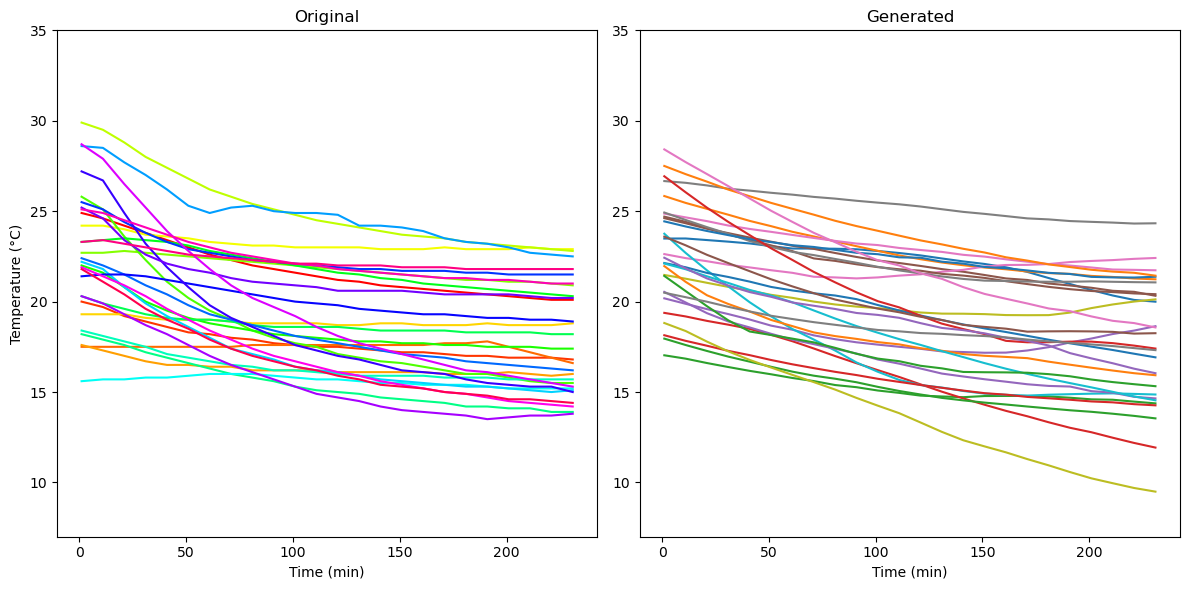

In [47]:
ns = total_size#*100
min_T, max_T = 15, 30
torch.manual_seed(0)
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (15 - 1) * torch.rand(ns)
Ts = T0 - difference
unique_intervals = df_c['interval'].unique()
num_unique_intervals = len(unique_intervals)
k_values, generated_data, fig, axs=model.generate_and_plot(mu_s, 
                        mean_q_mu_phy, 
                        mean_q_var_phy,
                        df=df_c,
                        num_unique_intervals=num_unique_intervals, 
                        ns=ns, 
                        T0=T0, 
                        Ts=Ts, 
                        t_uni=t_uni/240, 
                        axs_ylim=(7, 35),
                        plot=True, seed=0)

In [34]:
import tsgm
mmd_metric = tsgm.metrics.MMDMetric()
Gd = torch.stack(generated_data)
full_data = DataLoader(dataset)
original_data_list = []

# Iterate through the DataLoader
for batch in full_data:
    # Each batch is expected to be of shape [24, 1]
    # Add to the list
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)
# Check the shape
# print(original_data.shape)
mmd_metric(original_data, Gd)

0.070551629178226

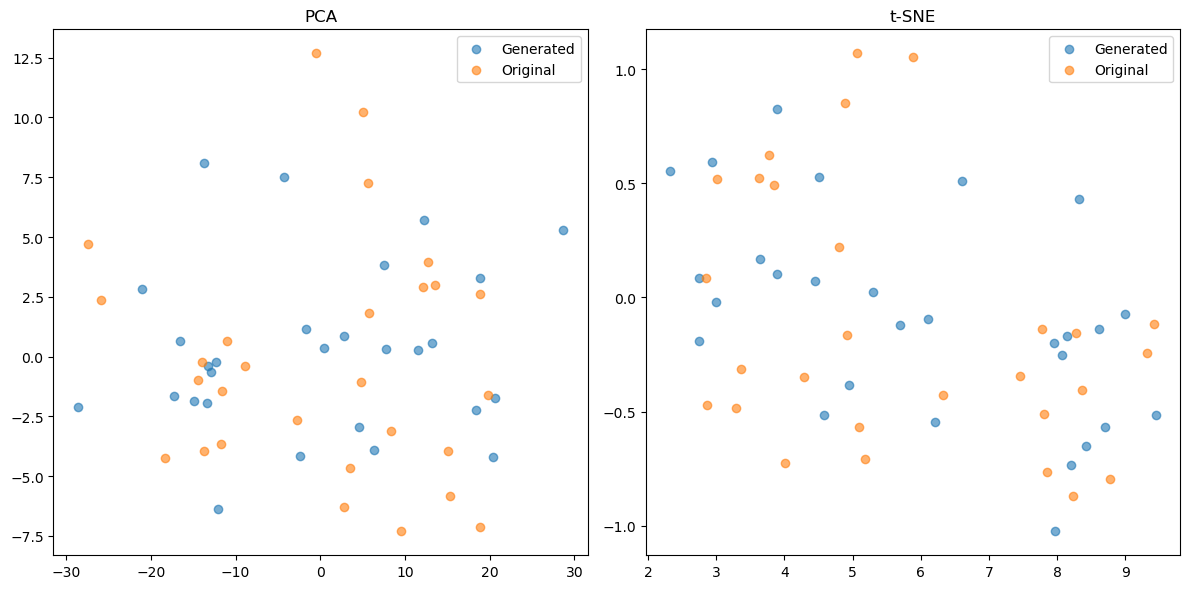

In [18]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Gd_reshaped = Gd.view(Gd.size(0), -1).numpy()
original_data_reshaped = original_data.view(original_data.size(0), -1).numpy()

data_combined = np.concatenate([Gd_reshaped, original_data_reshaped], axis=0)
labels = np.array(['Generated'] * Gd.size(0) + ['Original'] * original_data.size(0))

# PCA Visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_combined)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
for label in np.unique(labels):
    plt.scatter(pca_result[labels == label, 0], pca_result[labels == label, 1], label=label, alpha=0.6)
plt.title("PCA")

plt.legend()

# t-SNE Visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_combined)

plt.subplot(1, 2, 2)
for label in np.unique(labels):
    plt.scatter(tsne_result[labels == label, 0], tsne_result[labels == label, 1], label=label, alpha=0.6)
plt.title("t-SNE")

plt.legend()

plt.tight_layout()
plt.show()

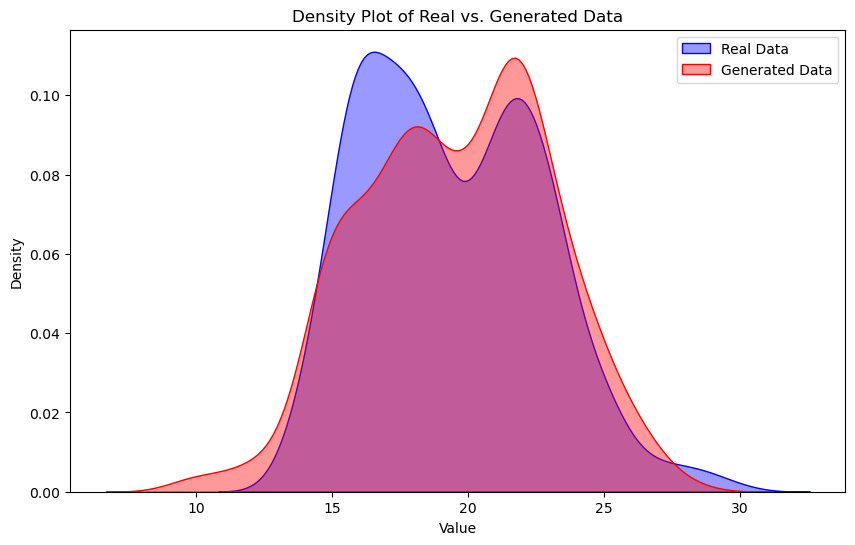

In [19]:
# Flatten the real and generated data to be one-dimensional
original_data_flattened = original_data.view(-1).numpy()
generated_data_flattened = Gd.view(-1).numpy()

# Plot overlapping density plots
plt.figure(figsize=(10, 6))
sns.kdeplot(original_data_flattened, label="Real Data", color="blue", fill=True, alpha=0.4)
sns.kdeplot(generated_data_flattened, label="Generated Data", color="red", fill=True, alpha=0.4)

# Customize plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Real vs. Generated Data')
plt.legend()
plt.show()


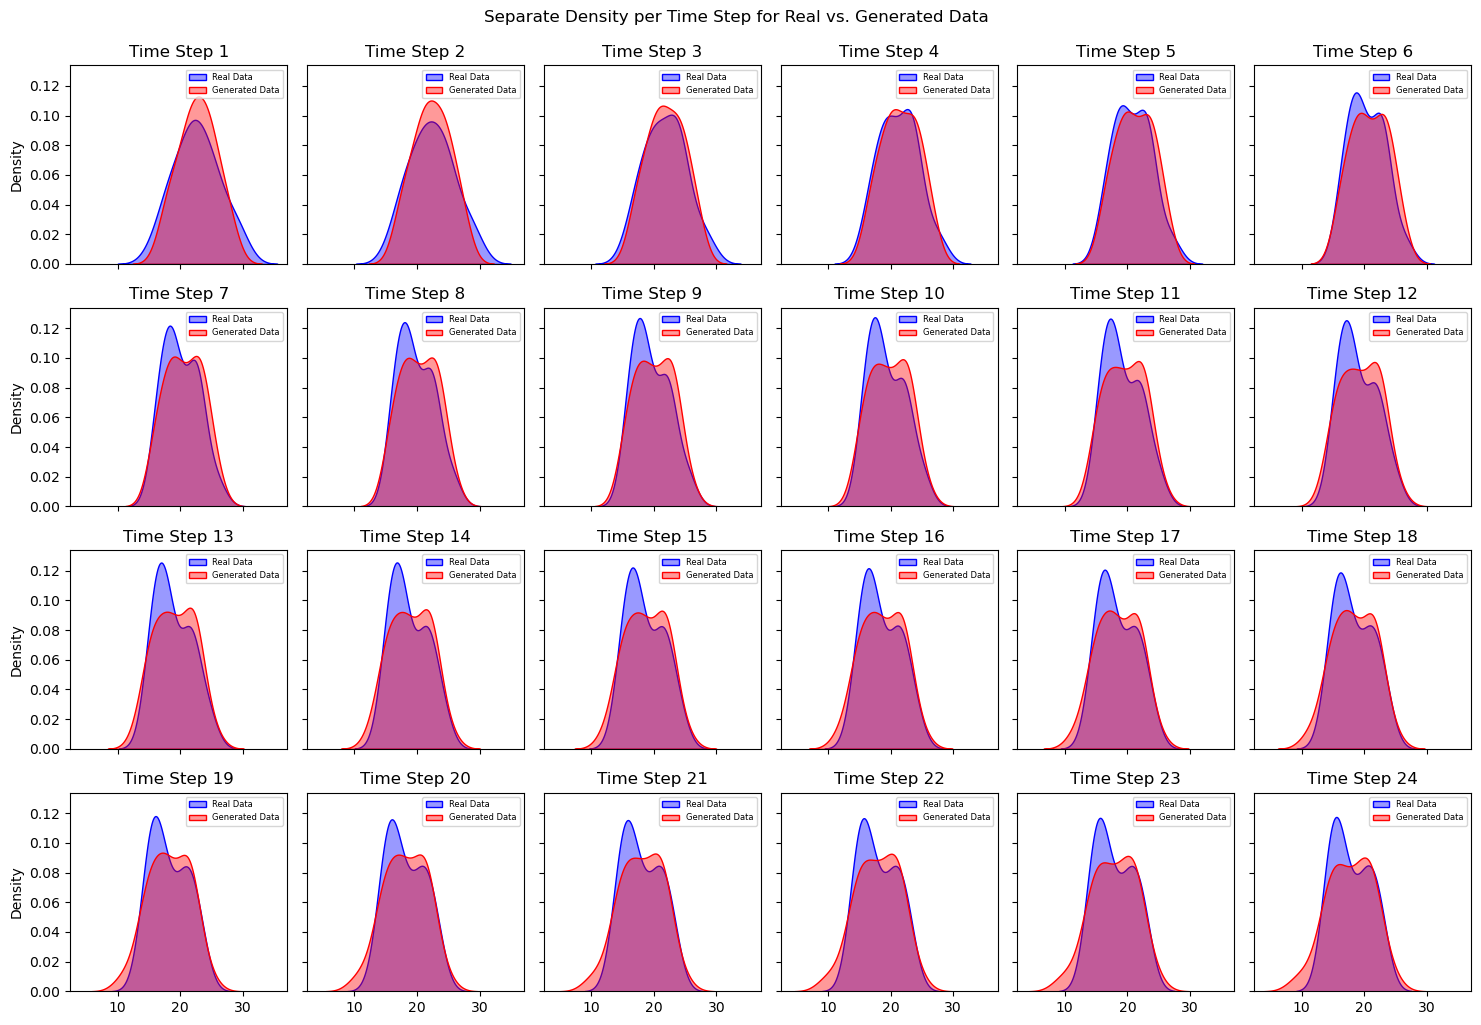

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data for real and generated samples
original_data_windowed = original_data.view(28, 24).numpy()  # shape (28, 24)
generated_data_windowed = Gd.view(ns, 24).numpy()  # shape (ns, 24)

# Set up the number of subplots (one for each time step)
num_time_steps = 24
fig, axes = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Loop through each time step and plot density
for t in range(num_time_steps):
    # Extract the values at time step `t` for real and generated data
    real_values_at_t = original_data_windowed[:, t]
    generated_values_at_t = generated_data_windowed[:, t]
    
    # Plot density for real and generated data at each time step
    sns.kdeplot(real_values_at_t, ax=axes[t], label="Real Data", color="blue", fill=True, alpha=0.4)
    sns.kdeplot(generated_values_at_t, ax=axes[t], label="Generated Data", color="red", fill=True, alpha=0.4)
    
    # Label each subplot
    axes[t].set_title(f'Time Step {t + 1}')
    axes[t].legend(loc='upper right', fontsize=6)

# Adjust layout and add global labels
plt.tight_layout()
fig.suptitle('Separate Density per Time Step for Real vs. Generated Data', y=1.02)
plt.show()


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


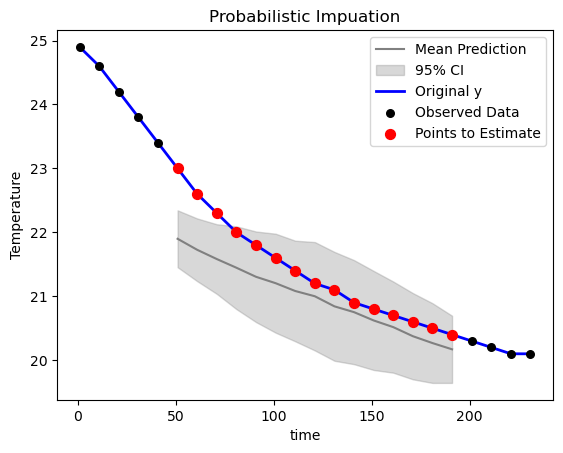

In [38]:
# Set number of samples
num_samples = 1000
dec_delta_values = []

# Load batch data and select the y values
for i, batch in enumerate(val_loader):
    if i == 2:  
        y = batch[0, :, 0]
        break

X = t_uni / 240  # Define X and normalize

# Calculate middle index and select 5 middle points to remove
num_points_to_remove = 15
mid_index = len(X) // 2  # Middle index
start_index = mid_index - num_points_to_remove // 2
indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

# Extract points to estimate and remove them from X, y, and batch
X_to_estimate = X[indices_to_remove]
y_to_estimate = y[indices_to_remove]
batch_to_estimate = batch[:, indices_to_remove, :]
batch_to_estimate = batch_to_estimate.squeeze()
T, Ts, t = batch_to_estimate[:, 0].unsqueeze(1), batch_to_estimate[:, 1].mean(), batch_to_estimate[:, 2]
T0 = T[0]
# Create a mask for filtering
mask = torch.ones(len(X), dtype=bool)
mask[indices_to_remove] = False

# Filter out the selected points from X, y, and batch
X_filtered = X[mask]
y_filtered = y[mask]
batch_filtered = batch[:, mask, :]
batch_filtered = batch_filtered.squeeze()
T_obs, Ts_obs, t_obs = batch_filtered[:, 0].unsqueeze(1), batch_filtered[:, 1].mean(), batch_filtered[:, 2]

# Set X_c to the missing middle points
X_c = X_to_estimate.unsqueeze(-1)

# Model evaluation with filtered batch
with torch.no_grad():
    _, _, _, q_mu_delta, q_var_delta, _, _, _, _ = model.encode(T_obs, t_obs)
    _, _, _, _, _, q_mu_phy, q_var_phy, _, _ = model.encode(T, t)
    mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu_delta, q_var_delta)
    # Loop to generate multiple `z` samples for interpolation
    for i in range(num_samples):
        # Reparameterize to get z
        k = model.reparameterization(q_mu_phy, q_var_phy)
        k = torch.exp(k)
        x_hat_phy = model.decode_phy(T0, t, Ts, k.mean())
        T0_broadcasted = torch.full_like(x_hat_phy, T0.item())
        Ts_broadcasted = torch.full_like(x_hat_phy, Ts.item())
        z_delta = model.reparameterization(mu_p, cov_p.diag())
        X_delta = torch.cat((x_hat_phy.unsqueeze(1), z_delta.unsqueeze(1), k, T0_broadcasted.unsqueeze(1), Ts_broadcasted.unsqueeze(1)), dim=1)
        # z_delta = z_delta.unsqueeze(1)
        dec_delta = model.decode_delta(X_delta)
        dec_phy = model.decode_phy(T0, t, Ts, k.mean())
        dec_delta_values.append(dec_phy.unsqueeze(1)+dec_delta)

# Convert stored dec values to a tensor for easy manipulation
dec_delta_values = torch.stack(dec_delta_values)  # Shape: (num_samples, num_points, 1)

# Calculate the mean and 95% confidence intervals
mean_dec = dec_delta_values.mean(dim=0).squeeze()  # Mean along the sample dimension
std_dec = dec_delta_values.std(dim=0).squeeze()    # Standard deviation along the sample dimension
ci_lower = mean_dec - 1.96 * std_dec         # Lower bound of 95% CI
ci_upper = mean_dec + 1.96 * std_dec         # Upper bound of 95% CI

# Plot the mean and 95% confidence intervals as shaded areas
plt.plot(X_c.numpy() * 240, mean_dec.numpy(), color="grey", label="Mean Prediction")
plt.fill_between(X_c.numpy().squeeze() * 240, ci_lower.numpy(), ci_upper.numpy(), color="grey", alpha=0.3, label="95% CI")

# Plot the original data, observed data points, and missing points for estimation
plt.plot(X.numpy() * 240, y.numpy(), label="Original y", color="blue", linewidth=2)
plt.scatter(X_filtered.numpy() * 240, y_filtered.numpy(), color="black", s=30, label="Observed Data", zorder=2)  # Black dots for observed data
plt.scatter(X_to_estimate.numpy() * 240, y_to_estimate.numpy(), color="red", s=50, label="Points to Estimate", zorder=3)  # Red dots for missing points

plt.xlabel("time")
plt.ylabel("Temperature")
plt.title("Probabilistic Impuation")
plt.legend()
plt.show()


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anac

Overall MAE across all validation batches: 0.48084689635369515


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


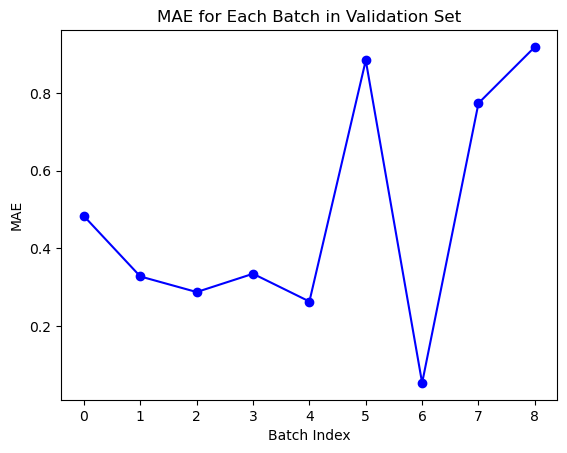

In [22]:
import torch
import matplotlib.pyplot as plt

# Set number of samples
num_samples = 1000
all_mae_values = []  # Store MAE values for each batch

# Iterate through the entire validation loader
for batch in val_loader:
    # Select the y values from the current batch
    y = batch[0, :, 0]  # Assuming y is the target variable in the first dimension
    
    X = t_uni / 240  # Define X and normalize

    # Calculate middle index and select points to remove for imputation
    num_points_to_remove = 10
    mid_index = len(X) // 2
    start_index = mid_index - num_points_to_remove // 2
    indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

    # Extract points to estimate and remove them from X, y, and batch
    X_to_estimate = X[indices_to_remove]
    y_to_estimate = y[indices_to_remove]
    batch_to_estimate = batch[:, indices_to_remove, :]
    batch_to_estimate = batch_to_estimate.squeeze()
    T, Ts, t = batch_to_estimate[:, 0].unsqueeze(1), batch_to_estimate[:, 1].mean(), batch_to_estimate[:, 2]
    T0 = T[0]

    # Create a mask to filter out selected points from X, y, and batch
    mask = torch.ones(len(X), dtype=bool)
    mask[indices_to_remove] = False

    X_filtered = X[mask]
    y_filtered = y[mask]
    batch_filtered = batch[:, mask, :]
    batch_filtered = batch_filtered.squeeze()
    T_obs, Ts_obs, t_obs = batch_filtered[:, 0].unsqueeze(1), batch_filtered[:, 1].mean(), batch_filtered[:, 2]

    # Set X_c to the missing points
    X_c = X_to_estimate.unsqueeze(-1)

    # Model evaluation with filtered batch
    dec_delta_values = []
    with torch.no_grad():
        # Encode and get q_mu and q_var
        _, _, _, q_mu_delta, q_var_delta, _, _, _, _ = model.encode(T_obs, t_obs)
        _, _, _, _, _, q_mu_phy, q_var_phy, _, _ = model.encode(T, t)
        
        # Predict using GP model for conditional mean and covariance
        mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu_delta, q_var_delta)
        
        # Loop to generate multiple `z` samples for interpolation
        for i in range(num_samples):
            # Reparameterize to get z
            k = model.reparameterization(q_mu_phy, q_var_phy)
            k = torch.clamp(k, min=0, max=10)
            x_hat_phy = model.decode_phy(T0, t, Ts, k.mean())
            T0_broadcasted = torch.full_like(x_hat_phy, T0.item())
            Ts_broadcasted = torch.full_like(x_hat_phy, Ts.item())
            z_delta = model.reparameterization(mu_p, cov_p.diag())
            X_delta = torch.cat((x_hat_phy.unsqueeze(1), z_delta.unsqueeze(1), k, T0_broadcasted.unsqueeze(1), Ts_broadcasted.unsqueeze(1)), dim=1)
            dec_delta = model.decode_delta(X_delta)
            dec_phy = model.decode_phy(T0, t, Ts, k.mean())
            dec_delta_values.append(dec_phy.unsqueeze(1) + dec_delta)

        # Convert stored dec values to a tensor for easy manipulation
        dec_delta_values = torch.stack(dec_delta_values)  # Shape: (num_samples, num_points, 1)

        # Calculate the mean prediction across samples
        mean_dec = dec_delta_values.mean(dim=0).squeeze()  # Mean along the sample dimension

        # Calculate MAE between the estimated (mean_dec) and the original y_to_estimate
        mae = torch.mean(torch.abs(mean_dec - y_to_estimate))
        all_mae_values.append(mae.item())  # Store MAE for this batch

# Compute overall MAE across all batches in val_loader
overall_mae = sum(all_mae_values) / len(all_mae_values)
print(f"Overall MAE across all validation batches: {overall_mae}")

# Optional: plot the MAE values across batches
plt.plot(all_mae_values, marker='o', linestyle='-', color="blue")
plt.xlabel("Batch Index")
plt.ylabel("MAE")
plt.title("MAE for Each Batch in Validation Set")
plt.show()


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(
/Users/michailspitieris/anac

Overall MAE across all validation batches: 0.7687085659967529


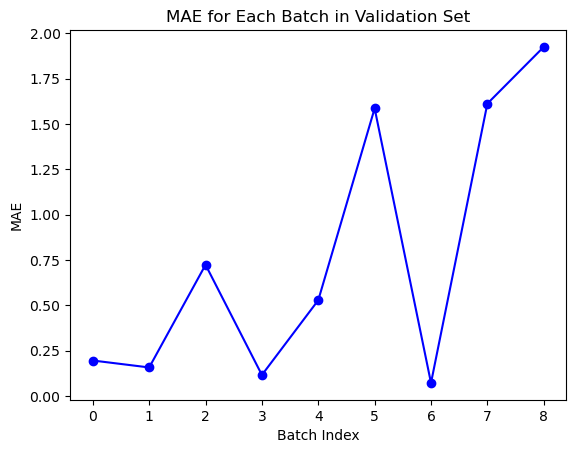

In [23]:
import torch
import matplotlib.pyplot as plt

# Set number of samples
num_samples = 1000
all_mae_values = []  # Store MAE values for each batch

# Iterate through the entire validation loader
for batch in val_loader:
    # Select the y values from the current batch
    y = batch[0, :, 0]  # Assuming y is the target variable in the first dimension
    
    X = t_uni / 240  # Define X and normalize

    # Calculate middle index and select points to remove for imputation
    num_points_to_remove = 15
    mid_index = len(X) // 2
    start_index = mid_index - num_points_to_remove // 2
    indices_to_remove = torch.arange(start_index, start_index + num_points_to_remove)

    # Extract points to estimate and remove them from X, y, and batch
    X_to_estimate = X[indices_to_remove]
    y_to_estimate = y[indices_to_remove]
    batch_to_estimate = batch[:, indices_to_remove, :]
    batch_to_estimate = batch_to_estimate.squeeze()
    T, Ts, t = batch_to_estimate[:, 0].unsqueeze(1), batch_to_estimate[:, 1].mean(), batch_to_estimate[:, 2]
    T0 = T[0]

    # Create a mask to filter out selected points from X, y, and batch
    mask = torch.ones(len(X), dtype=bool)
    mask[indices_to_remove] = False

    X_filtered = X[mask]
    y_filtered = y[mask]
    batch_filtered = batch[:, mask, :]
    batch_filtered = batch_filtered.squeeze()
    T_obs, Ts_obs, t_obs = batch_filtered[:, 0].unsqueeze(1), batch_filtered[:, 1].mean(), batch_filtered[:, 2]

    # Set X_c to the missing points
    X_c = X_to_estimate.unsqueeze(-1)

    # Model evaluation with filtered batch
    dec_delta_values = []
    with torch.no_grad():
        # Encode and get q_mu and q_var
        _, _, _, q_mu_delta, q_var_delta, _, _, _, _ = model.encode(T_obs, t_obs)
        _, _, _, _, _, q_mu_phy, q_var_phy, _, _ = model.encode(T, t)
        
        # Predict using GP model for conditional mean and covariance
        mu_p, cov_p = model.GP.cond_mu_cov(X_filtered, X_c, q_mu_delta, q_var_delta)
        
        # Loop to generate multiple `z` samples for interpolation
        for i in range(num_samples):
            # Reparameterize to get z
            k = model.reparameterization(q_mu_phy, q_var_phy)
            k = torch.clamp(k, min=0, max=10)
            x_hat_phy = model.decode_phy(T0, t, Ts, k.mean())
            T0_broadcasted = torch.full_like(x_hat_phy, T0.item())
            Ts_broadcasted = torch.full_like(x_hat_phy, Ts.item())
            z_delta = model.reparameterization(mu_p, cov_p.diag())
            X_delta = torch.cat((x_hat_phy.unsqueeze(1), z_delta.unsqueeze(1), k, T0_broadcasted.unsqueeze(1), Ts_broadcasted.unsqueeze(1)), dim=1)
            dec_delta = model.decode_delta(X_delta)
            dec_phy = model.decode_phy(T0, t, Ts, k.mean())
            dec_delta_values.append(dec_phy.unsqueeze(1) + dec_delta)

        # Convert stored dec values to a tensor for easy manipulation
        dec_delta_values = torch.stack(dec_delta_values)  # Shape: (num_samples, num_points, 1)

        # Calculate the mean prediction across samples
        mean_dec = dec_delta_values.mean(dim=0).squeeze()  # Mean along the sample dimension

        # Calculate MAE between the estimated (mean_dec) and the original y_to_estimate
        mae = torch.mean(torch.abs(mean_dec - y_to_estimate))
        all_mae_values.append(mae.item())  # Store MAE for this batch

# Compute overall MAE across all batches in val_loader
overall_mae = sum(all_mae_values) / len(all_mae_values)
print(f"Overall MAE across all validation batches: {overall_mae}")

# Optional: plot the MAE values across batches
plt.plot(all_mae_values, marker='o', linestyle='-', color="blue")
plt.xlabel("Batch Index")
plt.ylabel("MAE")
plt.title("MAE for Each Batch in Validation Set")
plt.show()


/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/gpytorch/likelihoods/gaussian_likelihood.py:300: GPInputWarning: You have passed data through a FixedNoiseGaussianLikelihood that did not match the size of the fixed noise, *and* you did not specify noise. This is treated as a no-op.
  warnings.warn(


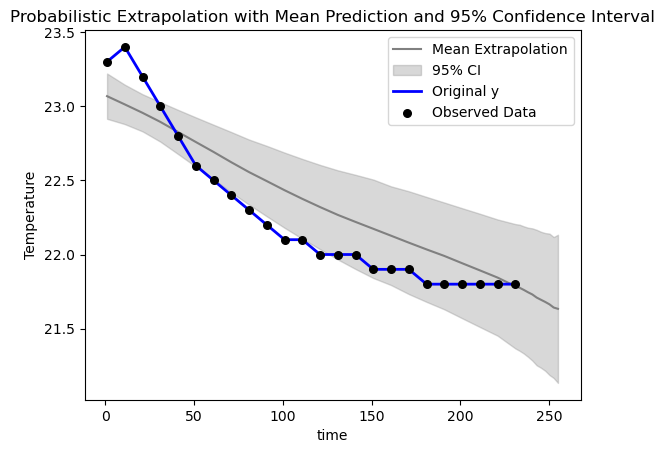

In [24]:
import torch
import matplotlib.pyplot as plt

# Set number of samples
num_samples = 1000
dec_delta_values = []

# Load batch data and select the y values
for i, batch in enumerate(val_loader):
    if i == 1:  
        y = batch[0, :, 0]
        break


X = t_uni / 240  

# Define X_c to extend beyond the maximum of X for extrapolation
X_c = torch.linspace(X.max() + 0.01, X.max() + 0.1, steps=10).unsqueeze(-1)

# Set up batch without removing points
batch = batch.squeeze()
T, Ts, t = batch[:, 0].unsqueeze(1), batch[:, 1].mean(), batch[:, 2]
T0 = T[0]

t_all=torch.cat((t, X_c.squeeze()), dim=0)
# Model evaluation with the full batch for extrapolation
with torch.no_grad():
    # Encode the observations and extrapolated points
    _, _, _, q_mu_delta, q_var_delta, _, _, _, _ = model.encode(T, t)
    _, _, _, _, _, q_mu_phy, q_var_phy, _, _ = model.encode(T, t)

    # Get mean and covariance predictions on X and X_c for extrapolation
    mu_p, cov_p = model.GP.cond_mu_cov(X, torch.cat((X.unsqueeze(1), X_c)), q_mu_delta, q_var_delta)

    # Loop to generate multiple `z` samples for extrapolation
    for i in range(num_samples):
        # Reparameterize to get z
        k = model.reparameterization(q_mu_phy, q_var_phy)
        k = torch.clamp(k, min=0, max=10)
        x_hat_phy = model.decode_phy(T0, t_all, Ts, k.mean())
        
        # Broadcast T0 and Ts for input compatibility
        T0_broadcasted = torch.full_like(x_hat_phy, T0.item())
        Ts_broadcasted = torch.full_like(x_hat_phy, Ts.item())
        k_broadcasted = torch.full_like(x_hat_phy, k.mean())
        
        # Concatenate inputs for delta decoding
        z_delta = model.reparameterization(mu_p, cov_p.diag())
        X_delta = torch.cat((x_hat_phy.unsqueeze(1), z_delta.unsqueeze(1), k_broadcasted.unsqueeze(1), T0_broadcasted.unsqueeze(1), Ts_broadcasted.unsqueeze(1)), dim=1)
        
        # Decode predictions
        dec_delta = model.decode_delta(X_delta)
        
        # Store the extrapolated delta values
        # dec_delta_values.append(dec_phy.unsqueeze(1) + dec_delta)
        dec_delta_values.append(dec_delta+x_hat_phy.unsqueeze(1))

# Convert stored extrapolated dec values to a tensor for easy manipulation
dec_delta_values = torch.stack(dec_delta_values)  # Shape: (num_samples, num_points, 1)

# Calculate the mean and 95% confidence intervals for extrapolated values
mean_dec = dec_delta_values.mean(dim=0).squeeze()  # Mean along the sample dimension
std_dec = dec_delta_values.std(dim=0).squeeze()    # Standard deviation along the sample dimension
ci_lower = mean_dec - 1.96 * std_dec               # Lower bound of 95% CI
ci_upper = mean_dec + 1.96 * std_dec               # Upper bound of 95% CI

# Plot the mean and 95% confidence intervals as shaded areas for extrapolation
plt.plot(t_all.numpy() * 240, mean_dec.numpy(), color="grey", label="Mean Extrapolation")
plt.fill_between(t_all.numpy().squeeze() * 240, ci_lower.numpy(), ci_upper.numpy(), color="grey", alpha=0.3, label="95% CI")

# Plot the original data points
plt.plot(X.numpy() * 240, y.numpy(), label="Original y", color="blue", linewidth=2)
plt.scatter(X.numpy() * 240, y.numpy(), color="black", s=30, label="Observed Data", zorder=2)  # Black dots for observed data

plt.xlabel("time")
plt.ylabel("Temperature")
plt.title("Probabilistic Extrapolation with Mean Prediction and 95% Confidence Interval")
plt.legend()
plt.show()


In [48]:
torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_cooling.pth')